In [ ]:
#####################################################################
#   PROJET 5 - Catégorisez automatiquement des questions            #
#-------------------------------------------------------------------#
#   NOTEBOOK DE TEST :                                              #
#      ---> test des différents modèles.                            #
#####################################################################

In [ ]:
#!pip install pyldavis

In [116]:
# built-in (librairie par défaut avec python)
import os

# Data
import pandas as pd
import numpy as np

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint
import tqdm
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Réduction de dimension
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer

# Algorithmes
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC       # SVM
From sklearn.svm import LinearSVC # SVM

# Métriques
from sklearn.metrics import accuracy_score, classification_report
From sklearn.metrics import confusion_matrix, f1_score

# Visualisation
import matplotlib.pyplot as plt
from PIL import Image

In [48]:
# Constantes
C_DATASET_SOURCE  = './data/source/'
C_DATASET_CLEANED = './data/cleaned/'

# 1. DONNEES

In [49]:
################################################
#      Chargement jeu de données               #
################################################
# Données nettoyées
df_all = pd.read_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', sep = '\t')

# Données nettoyées réduites
df = pd.read_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean_light.csv', sep = '\t')

In [50]:
print('df_all\tshape =', df_all.shape)
print('df\tshape =', df.shape)

df_all	shape = (185983, 17)
df	shape = (187959, 11)


In [51]:
df_all.columns

Index(['CreationDate', 'Id', 'Score', 'AnswerCount', '_Text', '_Tag_1',
       '_Tag_2', '_Text_sans_html', '_Text_tokens', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_len_Text', '_Tokens_text_clean',
       '_Tokens_stemmer_clean', '_Tokens_lemma_clean', '_len_Text_clean'],
      dtype='object')

In [52]:
df.columns

Index(['Id', 'Score', 'AnswerCount', '_Tag_1', '_Tag_2', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_Tokens_text_clean',
       '_Tokens_stemmer_clean', '_Tokens_lemma_clean'],
      dtype='object')

# 1.1. CORPUS TEXTE

In [ ]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.

In [60]:
# Colonne _Text_clean
corpus_text = ' '.join(df['_Text_clean'])

print('taille corpus_text =', f"{len(corpus_text):,}", '\n') # avec séparateur de milliers
print(corpus_text[:1_000])

taille corpus_text = 18,420,169 

torn sparse enormous matrices summation copula rare sea multidimensional sparse preset physically construction lazily beforehand construction integral guard excellent shame broad pod atomic knew boost certainly transact radio regard needing enumerable repeater wizard hat hat clearer hosting asp spill debate hardly intricate ground lie guy afraid pathetic suggesting shudder lars seamlessly office vista subscribe corrected respond enterprise reliability crucial scalable educated intervention experimental confident oversight vista filing acquisition acquisition shot drastically holy war consolidate distribute commons everybody bracket tax designer designer designer assembly undeclared designer shifting assembly worried hy adrian dropping vista asp sticking vista significance underscore subsection audience wap wap wap wap wap stripped variation agent safari eclipse tuning encryption suffice reckon infrastructure viable asymmetric encryption explorer sittin

In [61]:
# Colonne _Stemmer_clean
corpus_stemmer = ' '.join(df['_Stemmer_clean'])

print('taille corpus_stemmer =', f"{len(corpus_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_stemmer[:1_000])

taille corpus_stemmer = 16,011,771 

torn spars enorm matric summat copula rare sea multidimension spars preset physic construct lazili beforehand construct integr guard excel shame broad pod atom knew boost certainli transact radio regard need enumer repeat wizard hat hat clearer host asp spill debat hardli intric ground lie guy afraid pathet suggest shudder lar seamlessli offic vista subscrib correct respond enterpris reliabl crucial scalabl educ intervent experiment confid oversight vista file acquisit acquisit shot drastic holi war consolid distribut common everybodi bracket tax design design design assembl undeclar design shift assembl worri hy adrian drop vista asp stick vista signific underscor subsect audienc wap wap wap wap wap strip variat agent safari eclips tune encrypt suffic reckon infrastructur viabl asymmetr encrypt explor sit thumb mime andi thumb wed wed asp common design flexibl design portabl busi consider awkward admit note neat hell keen firm vista elev elev elev 

In [62]:
# Colonne _Lemma_clean
corpus_lemma = ' '.join(df['_Lemma_clean'])

print('taille corpus_lemma =', f"{len(corpus_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_lemma[:1_000])

taille corpus_lemma = 18,382,950 

torn sparse enormous matrix summation copula rare sea multidimensional sparse preset physically construction lazily beforehand construction integral guard excellent shame broad pod atomic knew boost certainly transact radio regard needing enumerable repeater wizard hat hat clearer hosting asp spill debate hardly intricate ground lie guy afraid pathetic suggesting shudder lars seamlessly office vista subscribe corrected respond enterprise reliability crucial scalable educated intervention experimental confident oversight vista filing acquisition acquisition shot drastically holy war consolidate distribute common everybody bracket tax designer designer designer assembly undeclared designer shifting assembly worried hy adrian dropping vista asp sticking vista significance underscore subsection audience wap wap wap wap wap stripped variation agent safari eclipse tuning encryption suffice reckon infrastructure viable asymmetric encryption explorer sitting 

# 1.2. TOKEN TEXTE

In [63]:
# Colonne _Stemmer_clean
token_stemmer = corpus_stemmer.split()

print('taille token_stemmer =', f"{len(token_stemmer):,}")
print(token_stemmer[0:10])

taille token_stemmer = 2,431,781
['torn', 'spars', 'enorm', 'matric', 'summat', 'copula', 'rare', 'sea', 'multidimension', 'spars']


In [64]:
# Colonne _Lemma_clean
token_lemma = corpus_lemma.split()

print('taille token_lemma =', f"{len(token_lemma):,}")
print(token_lemma[0:10])

taille token_lemma = 2,431,424
['torn', 'sparse', 'enormous', 'matrix', 'summation', 'copula', 'rare', 'sea', 'multidimensional', 'sparse']


In [262]:
##########################################
#        DISTRIBUTION DES TOKENS         #
##########################################

In [65]:
count_stemmer = pd.Series(token_stemmer).value_counts()

# Nombre de valeurs uniques
print('count_stemmer :', len(count_stemmer), 'valeurs uniques')

count_stemmer : 11219 valeurs uniques


In [66]:
# Affichage des 20 premiers éléments
count = 0

for idx, name in enumerate(count_stemmer.index.tolist()):
    if (count < 20):
        print(count_stemmer[idx], "\t:", name)
    else:
        break
    count = count + 1

31204 	: spring
21921 	: react
17243 	: hibern
16460 	: td
16407 	: login
15624 	: angular
14283 	: android
14079 	: boot
13648 	: eclips
13576 	: asp
10565 	: schema
9860 	: bean
9743 	: boost
9367 	: train
9018 	: assembl
8932 	: navig
8603 	: annot
8507 	: scala
7741 	: catalina
7563 	: tomcat


In [67]:
count_lemma = pd.Series(token_lemma).value_counts()

# Nombre de valeurs uniques
print('count_lemma :', len(count_lemma), 'valeurs uniques')

count_lemma : 14349 valeurs uniques


In [68]:
# Affichage des 20 premiers éléments
count = 0

for idx, name in enumerate(count_lemma.index.tolist()):
    if (count < 20):
        print(count_lemma[idx], "\t:", name)
    else:
        break
    count = count + 1

31204 	: spring
21921 	: react
17242 	: hibernate
16460 	: td
16407 	: login
15624 	: angular
14283 	: android
13821 	: boot
13648 	: eclipse
13576 	: asp
10576 	: schema
9860 	: bean
9743 	: boost
8507 	: scala
8202 	: assembly
8044 	: annotation
7741 	: catalina
7563 	: tomcat
6897 	: swift
6495 	: spark


# 1.3. CORPUS LISTE DOC

In [ ]:
# https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
##############################################
#   Corpus sous forme de liste de documents  #
##############################################

In [69]:
corpus_liste_doc_stemmer = []
corpus_liste_doc_lemma   = []

# Updating corpus list : one string for one document :
# corpus = ['This is the first document.',
#           'This document is the second document.',
#           'And this is the third one.',
#           'Is this the first document?']

for index, row in df.iterrows():
    corpus_liste_doc_stemmer.append(row['_Stemmer_clean'])
    corpus_liste_doc_lemma.append(row['_Lemma_clean'])

In [70]:
print('taille corpus_liste_doc_stemmer =', f"{len(corpus_liste_doc_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_liste_doc_stemmer[:10]) # 10 premiers éléments de la liste

taille corpus_liste_doc_stemmer = 187,949 

['torn', 'spars enorm matric summat copula rare sea multidimension spars preset physic', 'construct lazili beforehand construct integr guard excel shame broad pod atom knew boost certainli', 'transact', 'radio regard need', 'enumer repeat wizard', 'hat hat clearer', 'host asp spill debat hardli intric ground lie guy afraid pathet suggest shudder lar seamlessli offic vista subscrib correct respond enterpris reliabl crucial scalabl educ intervent experiment confid oversight', 'vista file acquisit acquisit shot drastic', 'holi war consolid distribut common everybodi bracket tax']


In [71]:
print('taille corpus_liste_doc_lemma =', f"{len(corpus_liste_doc_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_liste_doc_lemma[:10])  # 10 premiers éléments de la liste

taille corpus_liste_doc_lemma = 187,949 

['torn', 'sparse enormous matrix summation copula rare sea multidimensional sparse preset physically', 'construction lazily beforehand construction integral guard excellent shame broad pod atomic knew boost certainly', 'transact', 'radio regard needing', 'enumerable repeater wizard', 'hat hat clearer', 'hosting asp spill debate hardly intricate ground lie guy afraid pathetic suggesting shudder lars seamlessly office vista subscribe corrected respond enterprise reliability crucial scalable educated intervention experimental confident oversight', 'vista filing acquisition acquisition shot drastically', 'holy war consolidate distribute common everybody bracket tax']


# 1.4. TAGS : CORPUS & TOKENS

In [72]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.
corpus_tags_1 = ' '.join(df['_Tag_1'])
corpus_tags_1[:500]

'java c++ c++ sql c# c# c# c# c# java c# asp.net http html c++ .net security image c# c# c# php performance c# c# python database asp.net c++ python c# c# c# c# c# html java python c++ .net css java javascript php c# asynchronous python sql c++ c# linux database linux python java shell html java java c# python windows image ios python c++ c++ python java android ruby-on-rails c# c# bash c# windows python jquery php javascript php asp.net php sql python java jquery windows java java algorithm php '

In [73]:
corpus_tags_2 = ' '.join(df['_Tag_2'])
corpus_tags_2[:500]

'exception / multithreading sql-server .net asp.net performance c++ .net json .net performance / / linux performance ssl / .net .net / http mysql .net xml windows postgresql / / / optimization / asp.net .net asp.net css jquery linux unit-testing performance / security / / .net / / sql-server performance .net / / bash sql c++ / string / / .net authentication / / iphone / linux windows sql c++ iphone ruby javascript / shell asp.net / linux ajax sql html / security arrays sql-server performance / / '

In [74]:
corpus_tags = corpus_tags_1 + ' ' + corpus_tags_2
corpus_tags[len(corpus_tags_1) - 100: len(corpus_tags_1) + 200] # affichage corpus à cheval entre corpus_1 et corpus_2

'n ruby-on-rails c++ node.js java ios android angular c++ python javascript python c++ c++ javascript exception / multithreading sql-server .net asp.net performance c++ .net json .net performance / / linux performance ssl / .net .net / http mysql .net xml windows postgresql / / / optimization / asp.n'

In [75]:
###########################
# Corpus au format token  #
###########################
token_tags = corpus_tags.split()
len(token_tags)

375898

In [76]:
print(token_tags[0:10])

['java', 'c++', 'c++', 'sql', 'c#', 'c#', 'c#', 'c#', 'c#', 'java']


In [77]:
count_tags = pd.Series(token_tags).value_counts()
count_tags

/                    62180
java                 23990
c#                   21983
javascript           21309
python               20925
                     ...  
cocoa-touch            393
jpa                    341
dataframe              302
twitter-bootstrap      286
spring-mvc             220
Name: count, Length: 100, dtype: int64

In [78]:
# Nombre de valeurs uniques
print('count_tags :', len(count_tags), 'valeurs uniques')

count_tags : 100 valeurs uniques


In [79]:
liste_tags = count_tags.index.tolist()
print(liste_tags)

['/', 'java', 'c#', 'javascript', 'python', 'c++', 'android', 'ios', '.net', 'html', 'php', 'objective-c', 'node.js', 'c', 'spring', 'jquery', 'linux', 'swift', 'sql', 'asp.net', 'ruby-on-rails', 'iphone', 'css', 'performance', 'reactjs', 'c++11', 'windows', 'mysql', 'python-3.x', 'json', 'r', 'django', 'unit-testing', 'ruby', 'macos', 'sql-server', 'arrays', 'typescript', 'multithreading', 'asp.net-mvc', 'xcode', 'algorithm', 'angular', 'amazon-web-services', 'wpf', 'git', 'pandas', 'database', 'visual-studio', 'docker', 'eclipse', 'scala', 'string', 'bash', 'machine-learning', 'angularjs', 'gcc', 'spring-boot', 'postgresql', 'laravel', 'image', 'rest', 'numpy', 'xml', 'asp.net-core', 'maven', 'hibernate', 'google-chrome', 'security', 'http', 'authentication', 'android-studio', 'assembly', 'ssl', 'firebase', 'qt', 'testing', 'templates', 'entity-framework', 'debugging', 'selenium', 'shell', 'python-2.7', 'ubuntu', 'ajax', 'list', 'asynchronous', 'mongodb', 'optimization', 'api', 'grad

# 2. MACHINE LEARNING NON SUPERVISE

# 2.1. TF-IDF

In [68]:
# https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

#############################################
#               TF-IDF matrix               #
#############################################
def tf_idf_matrix(corpus_liste_doc_in):
    # TF-IDF matrix
    tfidfvectorizer = TfidfVectorizer()
    train_data = tfidfvectorizer.fit_transform(corpus_liste_doc_in)

    sparsity = 1 - train_data.size / (train_data.shape[0] * train_data.shape[1])
    print("Sparsity =", sparsity)
    
    return tfidfvectorizer, train_data

In [15]:
# TF-IDF matrix du corpus corpus_stemmer
tfidfvectorizer_stemmer, train_data_stemmer = tf_idf_matrix(corpus_liste_doc_in = corpus_liste_doc_stemmer)

Sparsity = 0.9989575248242523


In [16]:
# TF-IDF matrix du corpus corpus_lemma
tfidfvectorizer_lemma, train_data_lemma = tf_idf_matrix(corpus_liste_doc_in = corpus_liste_doc_lemma)

Sparsity = 0.9991728921862256


# 2.2. TOPIC MODEL AVEC LDA (LATENT DIRICHLET ALLOCATION)

# 2.2.1. METHODE 1

In [ ]:
# Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data,
# which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.

In [91]:
################################################################
#    Topic modeling using LDA (Latent Dirichlet Allocation)    #
################################################################
# https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/
# https://www.pluralsight.com/guides/topic-identification-nlp
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

# num_components_in = number of topics or components
def topic_modeling_with_LDA(normalization_type_in,
                            num_components_in, 
                            num_word_per_topic_in, 
                            tfidfvectorizer_in, 
                            train_data_in):
    
    # Generate TF-IDF Features
    ###################################
    #          Perform LDA            #
    ###################################
    # Create LDA object
    model = LatentDirichletAllocation(n_components = num_components_in)
    
    # Fit and Transform SVD model on data
    lda_matrix = model.fit_transform(train_data_in)

    # Get Components 
    lda_components = model.components_
    
    
    ###################################
    #   Extract topics and terms      #
    ###################################
    # Print the topics with their terms
    terms = tfidfvectorizer_in.get_feature_names()
    
    
    # affichage
    for index, component in enumerate(lda_components):
        zipped = zip(terms, component)
        top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:num_word_per_topic_in]
        top_terms_list = list(dict(top_terms_key).keys())
        print("Topic " + str(index) + " : " , top_terms_list)
        
    return lda_components, terms

In [121]:
dict_tags = {}
for tag in liste_tags:
    dict_tags[tag] = 0
    print(tag, dict_tags[tag] )
    

/ 0
java 0
c# 0
javascript 0
python 0
c++ 0
android 0
ios 0
.net 0
html 0
php 0
objective-c 0
c 0
node.js 0
jquery 0
spring 0
linux 0
sql 0
swift 0
iphone 0
ruby-on-rails 0
asp.net 0
css 0
performance 0
c++11 0
windows 0
reactjs 0
python-3.x 0
mysql 0
json 0
django 0
unit-testing 0
ruby 0
r 0
arrays 0
sql-server 0
macos 0
xcode 0
wpf 0
multithreading 0
asp.net-mvc 0
typescript 0
algorithm 0
amazon-web-services 0
git 0
angular 0
pandas 0
visual-studio 0
string 0
database 0
bash 0
docker 0
eclipse 0
scala 0
machine-learning 0
gcc 0
angularjs 0
postgresql 0
image 0
xml 0
laravel 0
rest 0
spring-boot 0
numpy 0
google-chrome 0
asp.net-core 0
maven 0
security 0
hibernate 0
http 0
qt 0
android-studio 0
ssl 0
authentication 0
firebase 0
assembly 0
templates 0
testing 0
debugging 0
shell 0
entity-framework 0
python-2.7 0
list 0
selenium 0
ubuntu 0
ajax 0
asynchronous 0
mongodb 0
regex 0
optimization 0
api 0
gradle 0
winforms 0
exception 0
cocoa 0
cocoa-touch 0
jpa 0
dataframe 0
twitter-bootstra

In [185]:
def graphique_topic_modeling_with_LDA(normalization_type_in, num_word_per_topic_in, lda_components_in, terms_in):
    
    # Dictionnaire avec le nombre de tags rencontrés
    dict_tags = {}
    
    
    for index_topic, component in enumerate(lda_components_in):
            zipped = zip(terms_in, component)
            top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:num_word_per_topic_in]
            top_terms_list = list(dict(top_terms_key).keys())
            print('\n\n', '@' * 100)
            print('Topic ' + str(index_topic) + ' : ' , top_terms_list, '\n')
        
        
            # Initialisation d'un dictionnaire avec le nombre de tags rencontrés (avant d'étudier chaque
            # nouvelle liste de mots)
            for tag in liste_tags:
                dict_tags[tag] = 0
        
        
            for word in top_terms_list:
                if (normalization_type_in == 'lemma'):
                    colonne = '_Tokens_lemma_clean'
                else:
                    colonne = '_Tokens_stemmer_clean'

                # sous-dataframe contenant le mot
                df_word = df[df[colonne].str.contains(word)]
                print('word =', word, ', df_word.shape =', df_word.shape)
                
                # Parcours des lignes contenant le mot pour comptage
                for index_word, row in df_word.iterrows():
                    tag_1 = row['_Tag_1']
                    tag_2 = row['_Tag_2']
            
                    dict_tags[tag_1] = dict_tags[tag_1] + 1
                    dict_tags[tag_2] = dict_tags[tag_2] + 1            
                print('word =', word, ', _Tag_1 =', dict_tags[tag_1], ', _Tag_2 =', dict_tags[tag_2])
            
            print('\ndict_tags =', dict_tags, '\n')
            
            
            # Affichage graphique
            plt.figure(figsize = (12, 4))

            # Suppression des éléments les plus rares
            # https://www.mypycode.com/fr/Python/1001006101.html
            for key, value in dict(dict_tags).items():
                if ((key == '/') | (value <= 2000)):
                    del dict_tags[key]

            myList = dict_tags.items()
            print(myList)
            myList = sorted(myList) 
            x, y = zip(*myList) 

            # couleur
            if (normalization_type_in == 'lemma'):
                color = 'red'
            elif(normalization_type_in == 'stemmer'):
                color = 'green'
                
            plt.plot(x, y, marker = 'o', color = color)
            plt.xticks(rotation = 90)
            plt.xlabel('Key')
            plt.ylabel('Value')
            plt.title('Tags ' + normalization_type_in + ' - topic ' + str(index_topic) + ' : ' + str(top_terms_list))
            plt.show() 

In [176]:
####################################
# LDA corpus stemmer               #
####################################

In [92]:
lda_components_stemmer, terms_stemmer = topic_modeling_with_LDA(normalization_type_in = 'stemmer',
                                                                num_components_in     = 8, 
                                                                num_word_per_topic_in = 12, 
                                                                tfidfvectorizer_in    = tfidfvectorizer_stemmer, 
                                                                train_data_in         = train_data_stemmer)  # 4 min

Topic 0 :  ['doubl', 'vector', 'float', 'column', 'integ', 'audio', 'rang', 'matrix', 'sum', 'scala', 'express', 'oper']
Topic 1 :  ['div', 'react', 'compon', 'label', 'titl', 'cell', 'swift', 'grid', 'li', 'bind', 'render', 'span']
Topic 2 :  ['android', 'activ', 'anim', 'click', 'font', 'chrome', 'scroll', 'intent', 'overrid', 'canva', 'mobil', 'document']
Topic 3 :  ['token', 'password', 'authent', 'login', 'secur', 'certif', 'train', 'author', 'account', 'plot', 'proxi', 'domain']
Topic 4 :  ['entiti', 'asp', 'git', 'control', 'column', 'session', 'valid', 'person', 'tabl', 'rout', 'repositori', 'schema']
Topic 5 :  ['studio', 'visual', 'docker', 'angular', 'rubi', 'chrome', 'selenium', 'bash', 'browser', 'mac', 'shell', 'echo']
Topic 6 :  ['char', 'assembl', 'boost', 'oper', 'gener', 'lock', 'pointer', 'queue', 'clang', 'await', 'link', 'free']
Topic 7 :  ['spring', 'eclips', 'jar', 'apach', 'hibern', 'boot', 'depend', 'bean', 'annot', 'mock', 'tomcat', 'sun']


C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)




 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 0 :  ['doubl', 'vector', 'float', 'column', 'integ', 'audio', 'rang', 'matrix', 'sum', 'scala', 'express', 'oper'] 

word = doubl , df_word.shape = (4588, 11)
word = doubl , _Tag_1 = 728 , _Tag_2 = 241
word = vector , df_word.shape = (3219, 11)
word = vector , _Tag_1 = 251 , _Tag_2 = 451
word = float , df_word.shape = (4009, 11)
word = float , _Tag_1 = 1570 , _Tag_2 = 4427
word = column , df_word.shape = (7995, 11)
word = column , _Tag_1 = 3390 , _Tag_2 = 100
word = integ , df_word.shape = (8102, 11)
word = integ , _Tag_1 = 4339 , _Tag_2 = 243
word = audio , df_word.shape = (1721, 11)
word = audio , _Tag_1 = 1716 , _Tag_2 = 101
word = rang , df_word.shape = (8432, 11)
word = rang , _Tag_1 = 6808 , _Tag_2 = 1419
word = matrix , df_word.shape = (2097, 11)
word = matrix , _Tag_1 = 810 , _Tag_2 = 1177
word = sum , df_word.shape = (14088, 11)
word = sum , _Tag_1 = 2724 , _Tag_2 = 77

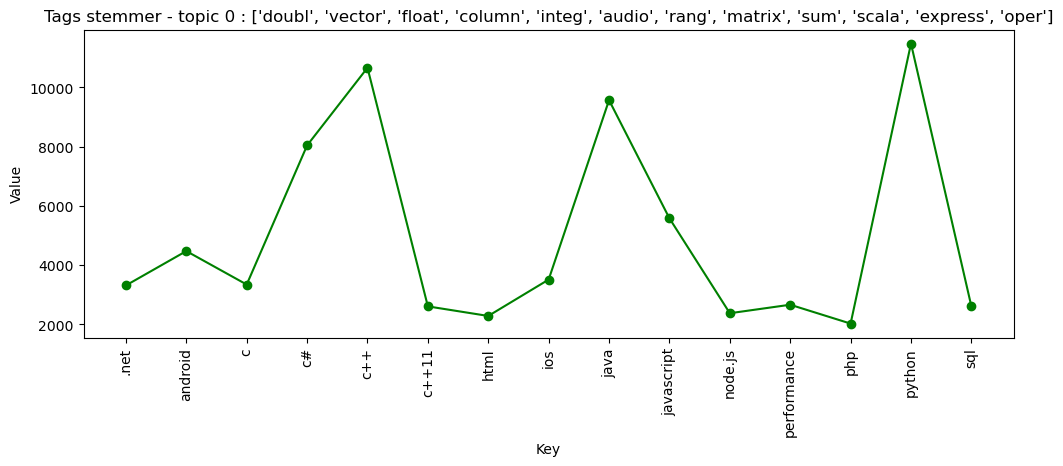



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 1 :  ['div', 'react', 'compon', 'label', 'titl', 'cell', 'swift', 'grid', 'li', 'bind', 'render', 'span'] 

word = div , df_word.shape = (10987, 11)
word = div , _Tag_1 = 4283 , _Tag_2 = 220
word = react , df_word.shape = (4978, 11)
word = react , _Tag_1 = 772 , _Tag_2 = 89
word = compon , df_word.shape = (6262, 11)
word = compon , _Tag_1 = 8582 , _Tag_2 = 5814
word = label , df_word.shape = (4800, 11)
word = label , _Tag_1 = 1237 , _Tag_2 = 296
word = titl , df_word.shape = (8496, 11)
word = titl , _Tag_1 = 673 , _Tag_2 = 10076
word = cell , df_word.shape = (2408, 11)
word = cell , _Tag_1 = 547 , _Tag_2 = 278
word = swift , df_word.shape = (3051, 11)
word = swift , _Tag_1 = 11503 , _Tag_2 = 358
word = grid , df_word.shape = (2307, 11)
word = grid , _Tag_1 = 860 , _Tag_2 = 12190
word = li , df_word.shape = (98868, 11)
word = li , _Tag_1 = 8933 , _Tag_2 = 45156
word = bind , df_

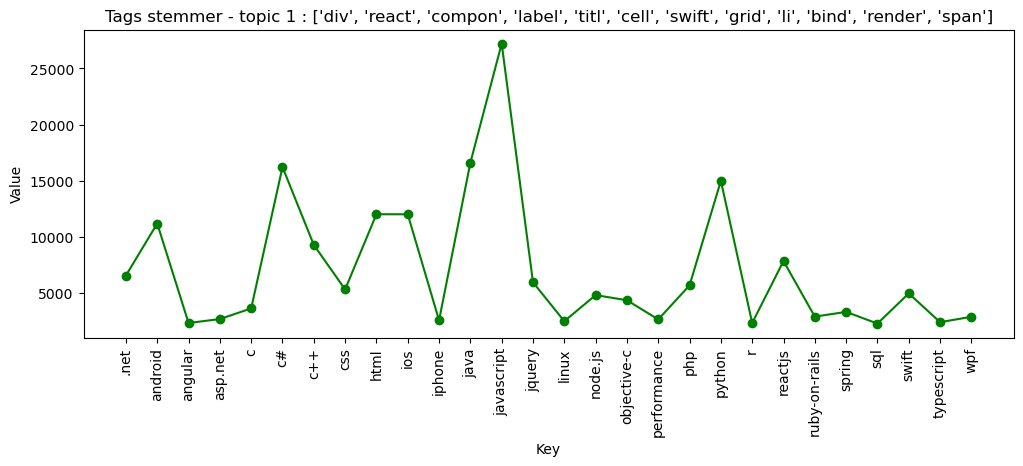



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 2 :  ['android', 'activ', 'anim', 'click', 'font', 'chrome', 'scroll', 'intent', 'overrid', 'canva', 'mobil', 'document'] 

word = android , df_word.shape = (14486, 11)
word = android , _Tag_1 = 12720 , _Tag_2 = 289
word = activ , df_word.shape = (9117, 11)
word = activ , _Tag_1 = 4737 , _Tag_2 = 148
word = anim , df_word.shape = (3543, 11)
word = anim , _Tag_1 = 2081 , _Tag_2 = 272
word = click , df_word.shape = (8817, 11)
word = click , _Tag_1 = 536 , _Tag_2 = 13019
word = font , df_word.shape = (2882, 11)
word = font , _Tag_1 = 497 , _Tag_2 = 13918
word = chrome , df_word.shape = (6233, 11)
word = chrome , _Tag_1 = 2143 , _Tag_2 = 428
word = scroll , df_word.shape = (2758, 11)
word = scroll , _Tag_1 = 5041 , _Tag_2 = 2298
word = intent , df_word.shape = (2437, 11)
word = intent , _Tag_1 = 1010 , _Tag_2 = 336
word = overrid , df_word.shape = (9165, 11)
word = overrid , _Tag_1

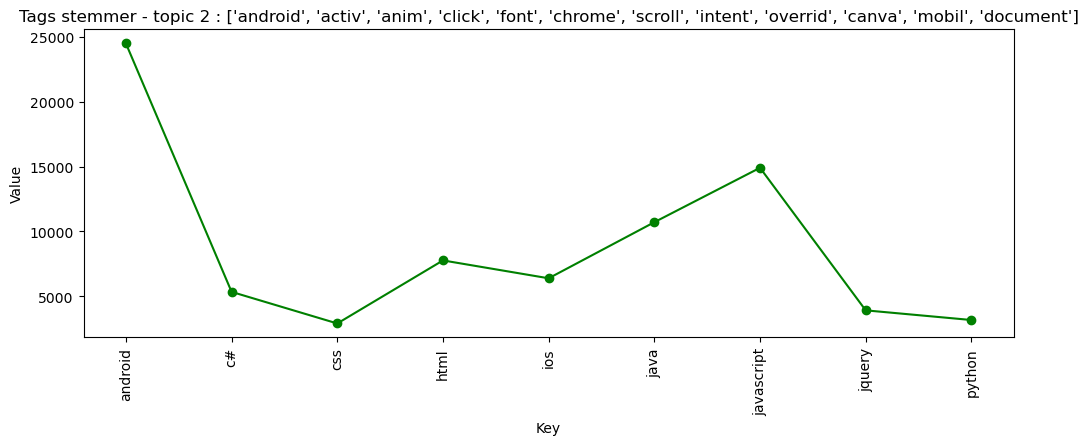



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 3 :  ['token', 'password', 'authent', 'login', 'secur', 'certif', 'train', 'author', 'account', 'plot', 'proxi', 'domain'] 

word = token , df_word.shape = (5035, 11)
word = token , _Tag_1 = 209 , _Tag_2 = 1638
word = password , df_word.shape = (7024, 11)
word = password , _Tag_1 = 1633 , _Tag_2 = 496
word = authent , df_word.shape = (5656, 11)
word = authent , _Tag_1 = 1045 , _Tag_2 = 317
word = login , df_word.shape = (5487, 11)
word = login , _Tag_1 = 684 , _Tag_2 = 266
word = secur , df_word.shape = (7033, 11)
word = secur , _Tag_1 = 1305 , _Tag_2 = 309
word = certif , df_word.shape = (2089, 11)
word = certif , _Tag_1 = 431 , _Tag_2 = 78
word = train , df_word.shape = (3794, 11)
word = train , _Tag_1 = 3793 , _Tag_2 = 166
word = author , df_word.shape = (4913, 11)
word = author , _Tag_1 = 884 , _Tag_2 = 385
word = account , df_word.shape = (3690, 11)
word = account , _Tag_1

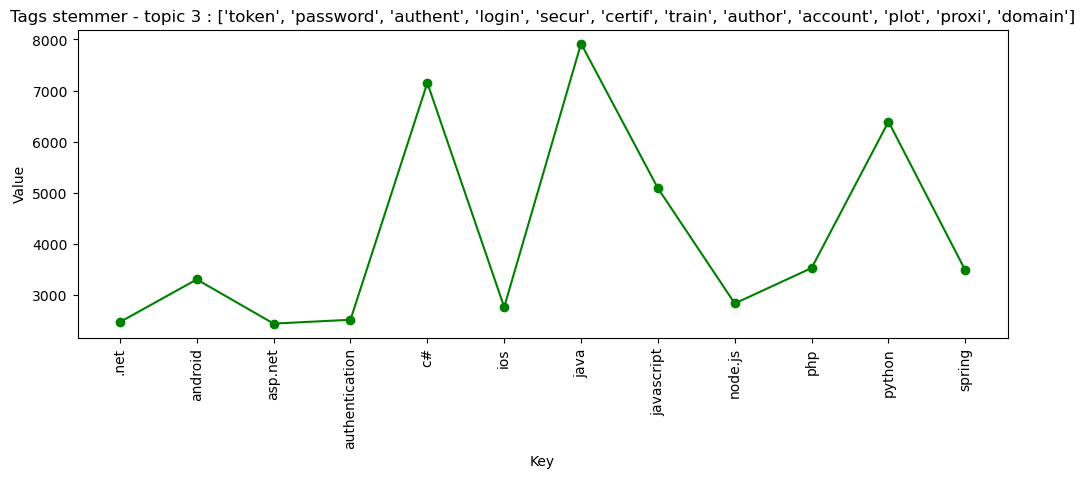



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 4 :  ['entiti', 'asp', 'git', 'control', 'column', 'session', 'valid', 'person', 'tabl', 'rout', 'repositori', 'schema'] 

word = entiti , df_word.shape = (5349, 11)
word = entiti , _Tag_1 = 526 , _Tag_2 = 199
word = asp , df_word.shape = (7744, 11)
word = asp , _Tag_1 = 5247 , _Tag_2 = 1721
word = git , df_word.shape = (4928, 11)
word = git , _Tag_1 = 278 , _Tag_2 = 160
word = control , df_word.shape = (7974, 11)
word = control , _Tag_1 = 951 , _Tag_2 = 6639
word = column , df_word.shape = (7995, 11)
word = column , _Tag_1 = 2668 , _Tag_2 = 192
word = session , df_word.shape = (6052, 11)
word = session , _Tag_1 = 575 , _Tag_2 = 10643
word = valid , df_word.shape = (5262, 11)
word = valid , _Tag_1 = 4224 , _Tag_2 = 465
word = person , df_word.shape = (2907, 11)
word = person , _Tag_1 = 1682 , _Tag_2 = 793
word = tabl , df_word.shape = (8936, 11)
word = tabl , _Tag_1 = 1462 , _T

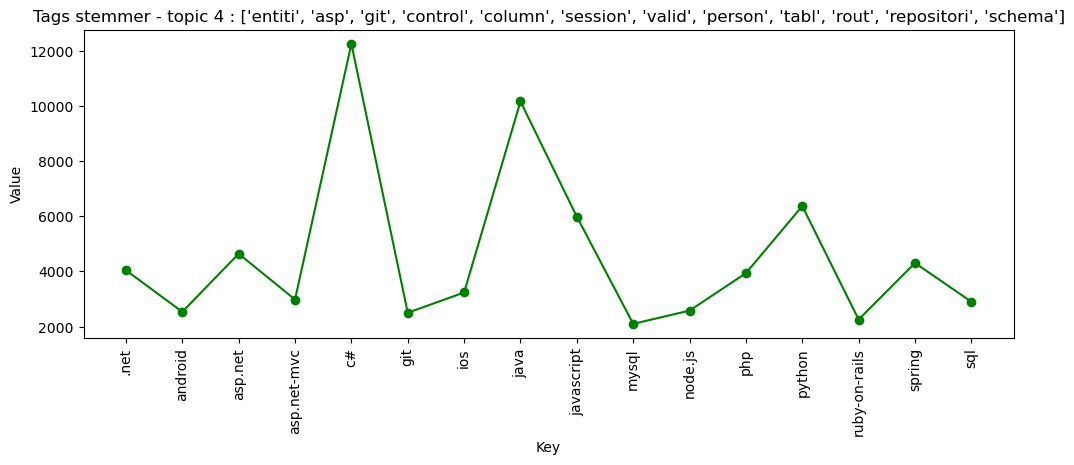



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 5 :  ['studio', 'visual', 'docker', 'angular', 'rubi', 'chrome', 'selenium', 'bash', 'browser', 'mac', 'shell', 'echo'] 

word = studio , df_word.shape = (7922, 11)
word = studio , _Tag_1 = 1851 , _Tag_2 = 126
word = visual , df_word.shape = (7201, 11)
word = visual , _Tag_1 = 234 , _Tag_2 = 36
word = docker , df_word.shape = (2165, 11)
word = docker , _Tag_1 = 309 , _Tag_2 = 46
word = angular , df_word.shape = (4145, 11)
word = angular , _Tag_1 = 1566 , _Tag_2 = 102
word = rubi , df_word.shape = (2827, 11)
word = rubi , _Tag_1 = 1535 , _Tag_2 = 1557
word = chrome , df_word.shape = (6233, 11)
word = chrome , _Tag_1 = 1420 , _Tag_2 = 291
word = selenium , df_word.shape = (1496, 11)
word = selenium , _Tag_1 = 1953 , _Tag_2 = 939
word = bash , df_word.shape = (2317, 11)
word = bash , _Tag_1 = 1011 , _Tag_2 = 266
word = browser , df_word.shape = (8799, 11)
word = browser , _Tag_1 =

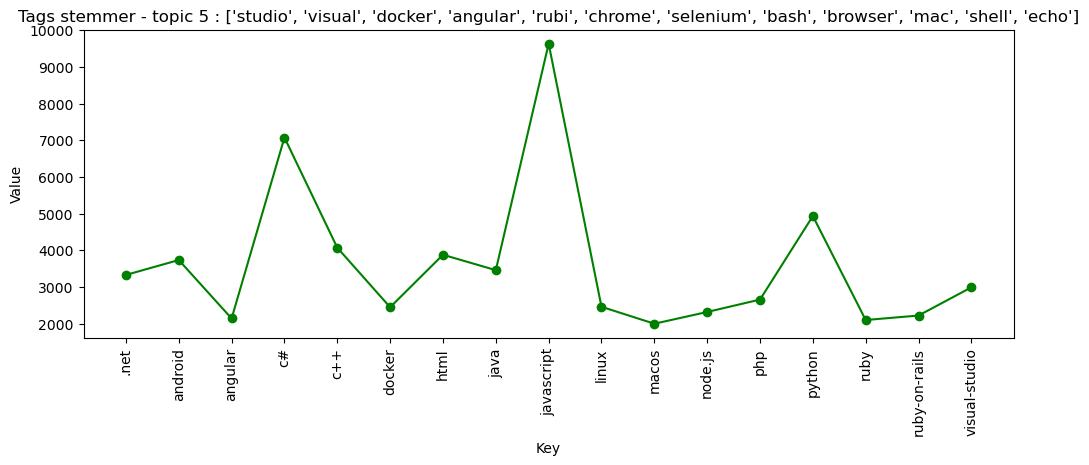



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 6 :  ['char', 'assembl', 'boost', 'oper', 'gener', 'lock', 'pointer', 'queue', 'clang', 'await', 'link', 'free'] 

word = char , df_word.shape = (6521, 11)
word = char , _Tag_1 = 239 , _Tag_2 = 9
word = assembl , df_word.shape = (3605, 11)
word = assembl , _Tag_1 = 2733 , _Tag_2 = 505
word = boost , df_word.shape = (1622, 11)
word = boost , _Tag_1 = 4103 , _Tag_2 = 465
word = oper , df_word.shape = (12292, 11)
word = oper , _Tag_1 = 2167 , _Tag_2 = 431
word = gener , df_word.shape = (12765, 11)
word = gener , _Tag_1 = 379 , _Tag_2 = 12686
word = lock , df_word.shape = (5934, 11)
word = lock , _Tag_1 = 4766 , _Tag_2 = 1154
word = pointer , df_word.shape = (3331, 11)
word = pointer , _Tag_1 = 10037 , _Tag_2 = 15647
word = queue , df_word.shape = (2454, 11)
word = queue , _Tag_1 = 2442 , _Tag_2 = 634
word = clang , df_word.shape = (2237, 11)
word = clang , _Tag_1 = 636 , _Tag_2 = 

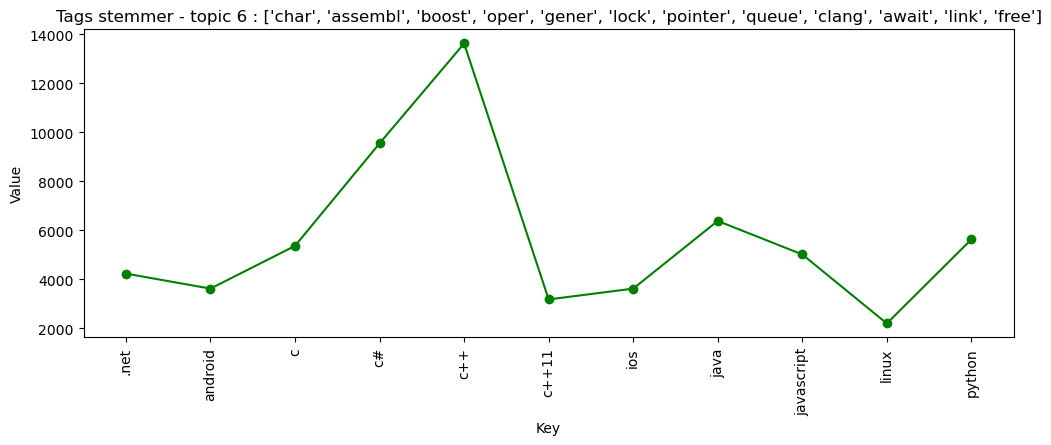



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 7 :  ['spring', 'eclips', 'jar', 'apach', 'hibern', 'boot', 'depend', 'bean', 'annot', 'mock', 'tomcat', 'sun'] 

word = spring , df_word.shape = (6634, 11)
word = spring , _Tag_1 = 4796 , _Tag_2 = 24
word = eclips , df_word.shape = (3357, 11)
word = eclips , _Tag_1 = 6775 , _Tag_2 = 309
word = jar , df_word.shape = (3631, 11)
word = jar , _Tag_1 = 1490 , _Tag_2 = 252
word = apach , df_word.shape = (4944, 11)
word = apach , _Tag_1 = 11582 , _Tag_2 = 1146
word = hibern , df_word.shape = (2580, 11)
word = hibern , _Tag_1 = 1435 , _Tag_2 = 269
word = boot , df_word.shape = (6094, 11)
word = boot , _Tag_1 = 2637 , _Tag_2 = 5575
word = depend , df_word.shape = (9300, 11)
word = depend , _Tag_1 = 331 , _Tag_2 = 112
word = bean , df_word.shape = (2467, 11)
word = bean , _Tag_1 = 19311 , _Tag_2 = 1746
word = annot , df_word.shape = (3161, 11)
word = annot , _Tag_1 = 3062 , _Tag_2 = 474

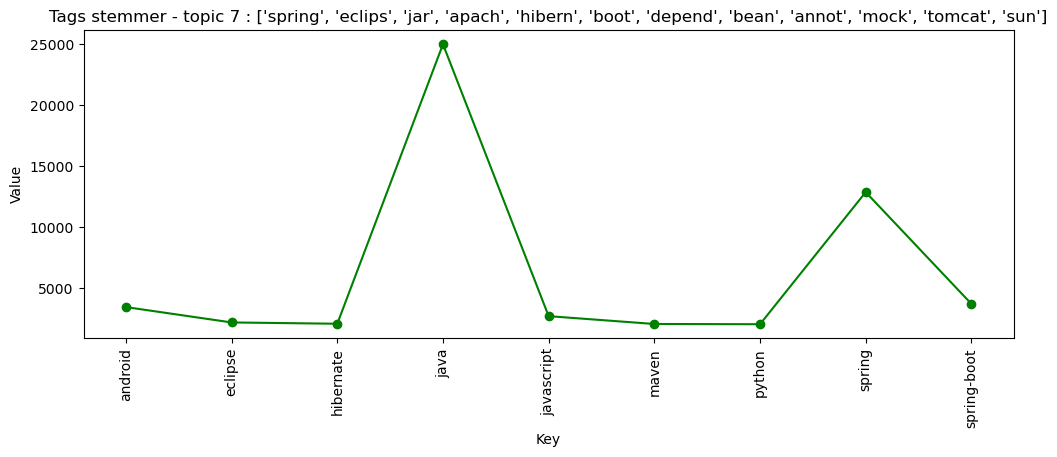

In [186]:
# graphique
graphique_topic_modeling_with_LDA(normalization_type_in = 'stemmer', 
                                  num_word_per_topic_in = 12, 
                                  lda_components_in     = lda_components_stemmer, 
                                  terms_in              = terms_stemmer)

In [ ]:
##################################################################
# ANALYSE GRAPHIQUE STEMMER :                                    #
# Synthèse des 5 premiers tags fournis par LDA pour chaque topic #
##################################################################
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 0 :  ['doubl', 'vector', 'float', 'column', 'integ', 'audio', 'rang', 'matrix', 'sum', 'scala', 'express', 'oper'] 
#
# ('python',     11482)
# ('c++',        10666)
# ('java',        9573)
# ('c#',          8045)
# ('javascript',  5584)
#
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 1 :  ['div', 'react', 'compon', 'label', 'titl', 'cell', 'swift', 'grid', 'li', 'bind', 'render', 'span'] 
#
# ('javascript', 27215)
# ('java',       16609)
# ('c#',         16225)
# ('python',     15002)
# ('html',       12023)
#
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 2 :  ['android', 'activ', 'anim', 'click', 'font', 'chrome', 'scroll', 'intent', 'overrid', 'canva', 'mobil', 
#             'document'] 
#
# ('android',    24496)
# ('javascript', 14907)
# ('java',       10711)
# ('html',        7763)
# ('ios',         6385)
# 
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 3 :  ['token', 'password', 'authent', 'login', 'secur', 'certif', 'train', 'author', 'account', 'plot', 'proxi',
#             'domain'] 
#
# ('java',       7918)
# ('c#',         7150)
# ('python',     6391)
# ('javascript', 5088)
# ('php',        3527)
#
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 4 :  ['entiti', 'asp', 'git', 'control', 'column', 'session', 'valid', 'person', 'tabl', 'rout', 'repositori',
#             'schema'] 
#
# ('c#',        12242)
# ('java',      10155)
# ('python',     6365)
# ('javascript', 5978)
# ('asp.net',    4636)
# 
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 5 :  ['studio', 'visual', 'docker', 'angular', 'rubi', 'chrome', 'selenium', 'bash', 'browser', 'mac', 'shell',
#             'echo'] 
#
# ('javascript', 9629)
# ('c#',         7074)
# ('python',     4935)
# ('c++',        4073)
# ('html',       3881)
#
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 6 :  ['char', 'assembl', 'boost', 'oper', 'gener', 'lock', 'pointer', 'queue', 'clang', 'await', 'link', 'free'] 
#
# ('c++',   13622)
# ('c#',     9548)
# ('java',   6385)
# ('python', 5633)
# ('c',      5367)
#
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 7 :  ['spring', 'eclips', 'jar', 'apach', 'hibern', 'boot', 'depend', 'bean', 'annot', 'mock', 'tomcat', 'sun'] 
#
# ('java',        25012)
# ('spring',      12872)
# ('spring-boot',  3703)
# ('android',      3438)
# ('javascript',   2693)

In [ ]:
####################################
# LDA corpus lemma                 #
####################################

In [179]:
lda_components_lemma, terms_lemma = topic_modeling_with_LDA(normalization_type_in = 'lemma',
                                                            num_components_in     = 8, 
                                                            num_word_per_topic_in = 12, 
                                                            tfidfvectorizer_in    = tfidfvectorizer_lemma, 
                                                            train_data_in         = train_data_lemma) # 6 min

Topic 0 :  ['token', 'password', 'asp', 'session', 'login', 'authentication', 'spring', 'security', 'visual', 'studio', 'certificate', 'controller']
Topic 1 :  ['matrix', 'float', 'double', 'plot', 'range', 'vector', 'sum', 'shape', 'algorithm', 'spark', 'train', 'column']
Topic 2 :  ['git', 'chrome', 'apache', 'eclipse', 'browser', 'jar', 'ruby', 'selenium', 'site', 'driver', 'dependency', 'remote']
Topic 3 :  ['char', 'pointer', 'operator', 'clang', 'boost', 'expression', 'constructor', 'vector', 'member', 'bool', 'assembly', 'generic']
Topic 4 :  ['div', 'font', 'swift', 'cell', 'click', 'scroll', 'grid', 'label', 'binding', 'title', 'nil', 'menu']
Topic 5 :  ['android', 'docker', 'play', 'audio', 'activity', 'intent', 'studio', 'camera', 'player', 'phone', 'permission', 'emulator']
Topic 6 :  ['column', 'entity', 'hibernate', 'spring', 'div', 'schema', 'product', 'person', 'validation', 'table', 'group', 'annotation']
Topic 7 :  ['react', 'angular', 'component', 'mock', 'export', '

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)




 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 0 :  ['token', 'password', 'asp', 'session', 'login', 'authentication', 'spring', 'security', 'visual', 'studio', 'certificate', 'controller'] 

word = token , df_word.shape = (5035, 11)
word = token , _Tag_1 = 209 , _Tag_2 = 1638
word = password , df_word.shape = (7024, 11)
word = password , _Tag_1 = 1633 , _Tag_2 = 496
word = asp , df_word.shape = (7744, 11)
word = asp , _Tag_1 = 5294 , _Tag_2 = 1664
word = session , df_word.shape = (6054, 11)
word = session , _Tag_1 = 188 , _Tag_2 = 7043
word = login , df_word.shape = (5487, 11)
word = login , _Tag_1 = 659 , _Tag_2 = 273
word = authentication , df_word.shape = (4645, 11)
word = authentication , _Tag_1 = 1798 , _Tag_2 = 438
word = spring , df_word.shape = (6637, 11)
word = spring , _Tag_1 = 9422 , _Tag_2 = 159
word = security , df_word.shape = (5465, 11)
word = security , _Tag_1 = 1760 , _Tag_2 = 469
word = visual , df_word.s

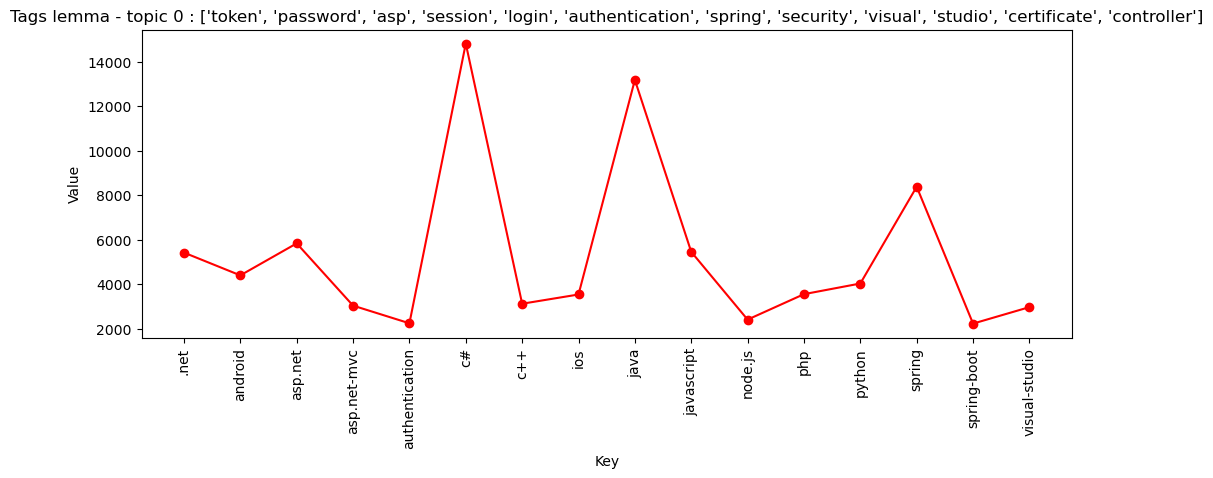



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 1 :  ['matrix', 'float', 'double', 'plot', 'range', 'vector', 'sum', 'shape', 'algorithm', 'spark', 'train', 'column'] 

word = matrix , df_word.shape = (2197, 11)
word = matrix , _Tag_1 = 114 , _Tag_2 = 283
word = float , df_word.shape = (4009, 11)
word = float , _Tag_1 = 1712 , _Tag_2 = 2380
word = double , df_word.shape = (4515, 11)
word = double , _Tag_1 = 1186 , _Tag_2 = 824
word = plot , df_word.shape = (2209, 11)
word = plot , _Tag_1 = 952 , _Tag_2 = 5188
word = range , df_word.shape = (8336, 11)
word = range , _Tag_1 = 5719 , _Tag_2 = 966
word = vector , df_word.shape = (3219, 11)
word = vector , _Tag_1 = 1366 , _Tag_2 = 1174
word = sum , df_word.shape = (14088, 11)
word = sum , _Tag_1 = 1943 , _Tag_2 = 583
word = shape , df_word.shape = (2540, 11)
word = shape , _Tag_1 = 4012 , _Tag_2 = 15122
word = algorithm , df_word.shape = (3436, 11)
word = algorithm , _Tag_1 = 102

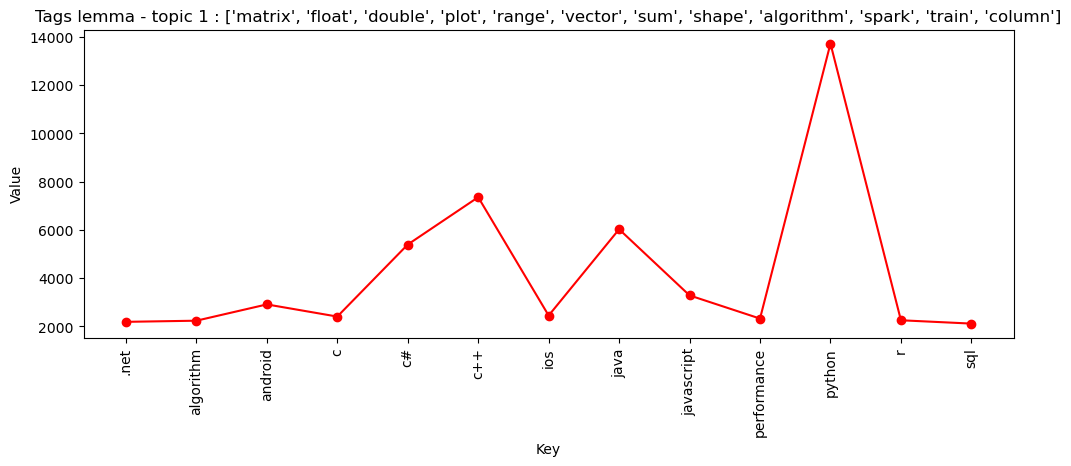



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 2 :  ['git', 'chrome', 'apache', 'eclipse', 'browser', 'jar', 'ruby', 'selenium', 'site', 'driver', 'dependency', 'remote'] 

word = git , df_word.shape = (4928, 11)
word = git , _Tag_1 = 206 , _Tag_2 = 128
word = chrome , df_word.shape = (6256, 11)
word = chrome , _Tag_1 = 849 , _Tag_2 = 238
word = apache , df_word.shape = (4944, 11)
word = apache , _Tag_1 = 3051 , _Tag_2 = 508
word = eclipse , df_word.shape = (3357, 11)
word = eclipse , _Tag_1 = 5030 , _Tag_2 = 709
word = browser , df_word.shape = (8799, 11)
word = browser , _Tag_1 = 530 , _Tag_2 = 399
word = jar , df_word.shape = (3631, 11)
word = jar , _Tag_1 = 2982 , _Tag_2 = 305
word = ruby , df_word.shape = (2827, 11)
word = ruby , _Tag_1 = 1978 , _Tag_2 = 1810
word = selenium , df_word.shape = (1496, 11)
word = selenium , _Tag_1 = 2603 , _Tag_2 = 1220
word = site , df_word.shape = (8813, 11)
word = site , _Tag_1 = 2294 

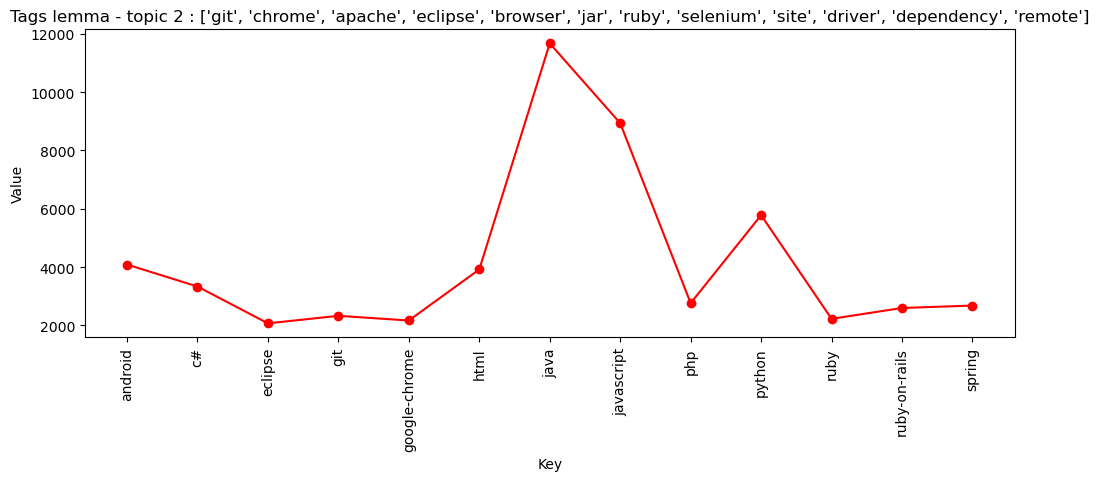



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 3 :  ['char', 'pointer', 'operator', 'clang', 'boost', 'expression', 'constructor', 'vector', 'member', 'bool', 'assembly', 'generic'] 

word = char , df_word.shape = (6521, 11)
word = char , _Tag_1 = 239 , _Tag_2 = 9
word = pointer , df_word.shape = (3331, 11)
word = pointer , _Tag_1 = 3802 , _Tag_2 = 3365
word = operator , df_word.shape = (2755, 11)
word = operator , _Tag_1 = 5282 , _Tag_2 = 4400
word = clang , df_word.shape = (2237, 11)
word = clang , _Tag_1 = 83 , _Tag_2 = 74
word = boost , df_word.shape = (1622, 11)
word = boost , _Tag_1 = 8256 , _Tag_2 = 681
word = expression , df_word.shape = (3274, 11)
word = expression , _Tag_1 = 1335 , _Tag_2 = 26
word = constructor , df_word.shape = (5226, 11)
word = constructor , _Tag_1 = 10038 , _Tag_2 = 8454
word = vector , df_word.shape = (3219, 11)
word = vector , _Tag_1 = 1979 , _Tag_2 = 766
word = member , df_word.shape = (428

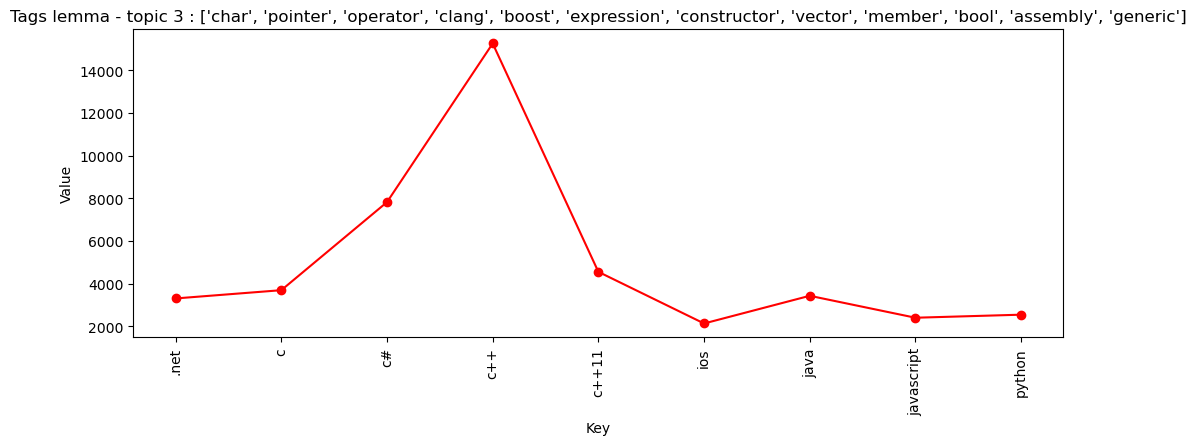



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 4 :  ['div', 'font', 'swift', 'cell', 'click', 'scroll', 'grid', 'label', 'binding', 'title', 'nil', 'menu'] 

word = div , df_word.shape = (10987, 11)
word = div , _Tag_1 = 4283 , _Tag_2 = 220
word = font , df_word.shape = (2882, 11)
word = font , _Tag_1 = 793 , _Tag_2 = 3390
word = swift , df_word.shape = (3051, 11)
word = swift , _Tag_1 = 4944 , _Tag_2 = 185
word = cell , df_word.shape = (2946, 11)
word = cell , _Tag_1 = 261 , _Tag_2 = 143
word = click , df_word.shape = (8817, 11)
word = click , _Tag_1 = 378 , _Tag_2 = 7188
word = scroll , df_word.shape = (2758, 11)
word = scroll , _Tag_1 = 5772 , _Tag_2 = 2583
word = grid , df_word.shape = (2307, 11)
word = grid , _Tag_1 = 462 , _Tag_2 = 8922
word = label , df_word.shape = (4800, 11)
word = label , _Tag_1 = 5492 , _Tag_2 = 3183
word = binding , df_word.shape = (3155, 11)
word = binding , _Tag_1 = 3009 , _Tag_2 = 70
word = t

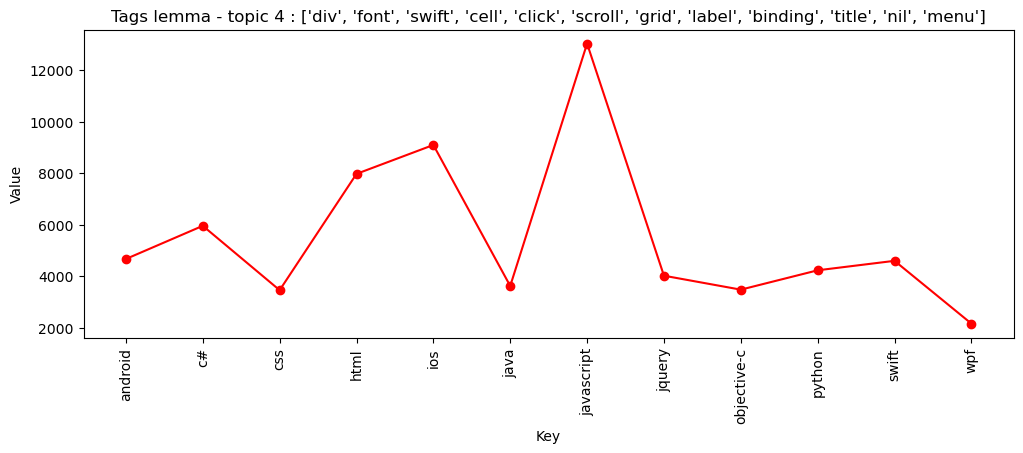



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 5 :  ['android', 'docker', 'play', 'audio', 'activity', 'intent', 'studio', 'camera', 'player', 'phone', 'permission', 'emulator'] 

word = android , df_word.shape = (14486, 11)
word = android , _Tag_1 = 12720 , _Tag_2 = 289
word = docker , df_word.shape = (2165, 11)
word = docker , _Tag_1 = 274 , _Tag_2 = 81
word = play , df_word.shape = (7836, 11)
word = play , _Tag_1 = 14452 , _Tag_2 = 381
word = audio , df_word.shape = (1721, 11)
word = audio , _Tag_1 = 2215 , _Tag_2 = 126
word = activity , df_word.shape = (3891, 11)
word = activity , _Tag_1 = 17939 , _Tag_2 = 405
word = intent , df_word.shape = (2437, 11)
word = intent , _Tag_1 = 525 , _Tag_2 = 141
word = studio , df_word.shape = (7922, 11)
word = studio , _Tag_1 = 21321 , _Tag_2 = 545
word = camera , df_word.shape = (1512, 11)
word = camera , _Tag_1 = 21850 , _Tag_2 = 547
word = player , df_word.shape = (1271, 11)
word = 

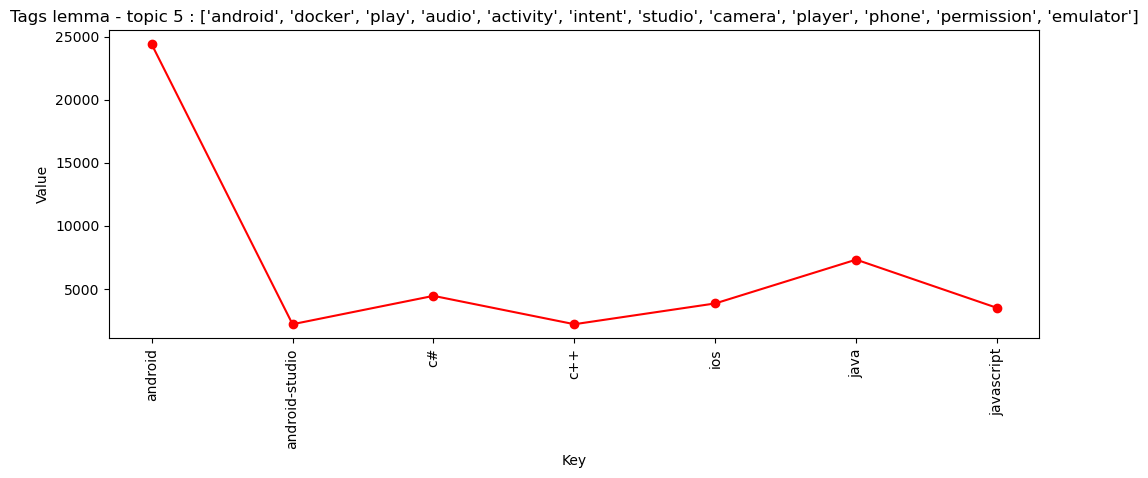



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 6 :  ['column', 'entity', 'hibernate', 'spring', 'div', 'schema', 'product', 'person', 'validation', 'table', 'group', 'annotation'] 

word = column , df_word.shape = (7995, 11)
word = column , _Tag_1 = 1820 , _Tag_2 = 72
word = entity , df_word.shape = (7230, 11)
word = entity , _Tag_1 = 813 , _Tag_2 = 286
word = hibernate , df_word.shape = (2577, 11)
word = hibernate , _Tag_1 = 1744 , _Tag_2 = 427
word = spring , df_word.shape = (6637, 11)
word = spring , _Tag_1 = 9660 , _Tag_2 = 92
word = div , df_word.shape = (10987, 11)
word = div , _Tag_1 = 5017 , _Tag_2 = 398
word = schema , df_word.shape = (3057, 11)
word = schema , _Tag_1 = 3159 , _Tag_2 = 8122
word = product , df_word.shape = (5915, 11)
word = product , _Tag_1 = 738 , _Tag_2 = 10153
word = person , df_word.shape = (2907, 11)
word = person , _Tag_1 = 1162 , _Tag_2 = 514
word = validation , df_word.shape = (3140, 11)
wo

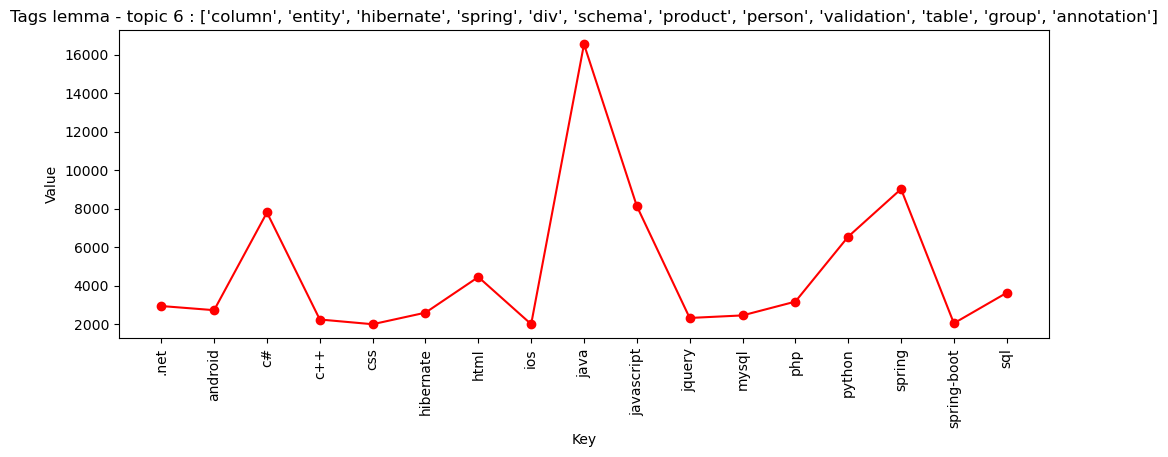



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 7 :  ['react', 'angular', 'component', 'mock', 'export', 'typescript', 'err', 'prop', 'loader', 'fragment', 'router', 'div'] 

word = react , df_word.shape = (4978, 11)
word = react , _Tag_1 = 207 , _Tag_2 = 25
word = angular , df_word.shape = (4145, 11)
word = angular , _Tag_1 = 1516 , _Tag_2 = 137
word = component , df_word.shape = (6261, 11)
word = component , _Tag_1 = 5989 , _Tag_2 = 4164
word = mock , df_word.shape = (2160, 11)
word = mock , _Tag_1 = 335 , _Tag_2 = 94
word = export , df_word.shape = (5209, 11)
word = export , _Tag_1 = 225 , _Tag_2 = 6185
word = typescript , df_word.shape = (1651, 11)
word = typescript , _Tag_1 = 3477 , _Tag_2 = 6530
word = err , df_word.shape = (15731, 11)
word = err , _Tag_1 = 1989 , _Tag_2 = 887
word = prop , df_word.shape = (8993, 11)
word = prop , _Tag_1 = 1743 , _Tag_2 = 15047
word = loader , df_word.shape = (1950, 11)
word = loader ,

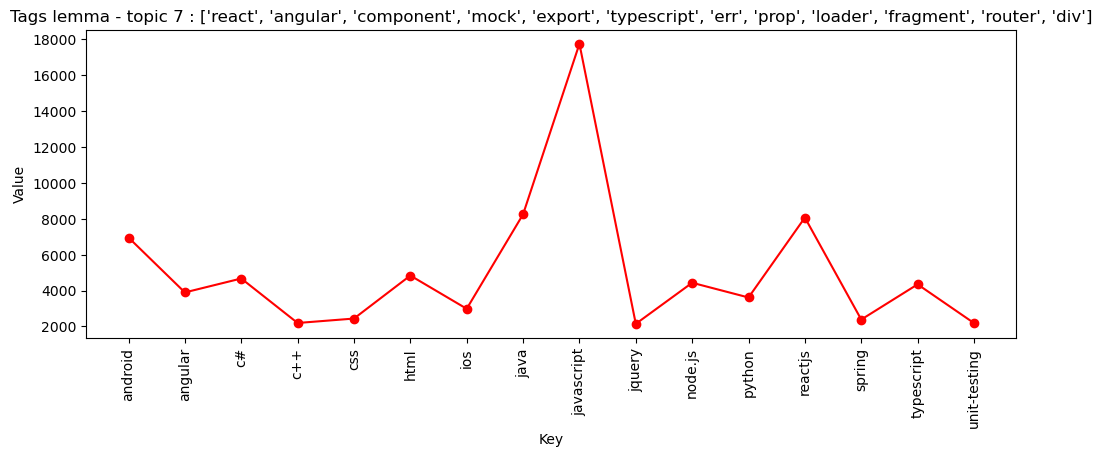

In [187]:
# graphique
graphique_topic_modeling_with_LDA(normalization_type_in = 'lemma', 
                                  num_word_per_topic_in = 12, 
                                  lda_components_in     = lda_components_lemma, 
                                  terms_in              = terms_lemma)

In [ ]:
##################################################################
# ANALYSE GRAPHIQUE LEMMA :                                      #
# Synthèse des 5 premiers tags fournis par LDA pour chaque topic #
##################################################################
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 0 :  ['token', 'password', 'asp', 'session', 'login', 'authentication', 'spring', 'security', 'visual', 'studio',
#             'certificate', 'controller'] 
# 
# ('c#',        14811)
# ('java',      13179)
# ('spring',     8377)
# ('asp.net',    5832)
# ('javascript', 5451) 
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 1 :  ['matrix', 'float', 'double', 'plot', 'range', 'vector', 'sum', 'shape', 'algorithm', 'spark', 'train', 
#             'column'] 
# 
# ('python',   13722)
# ('c++',       7357)
# ('java',       6028)
# ('c#',         5395)
# ('javascript', 3287)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 2 :  ['git', 'chrome', 'apache', 'eclipse', 'browser', 'jar', 'ruby', 'selenium', 'site', 'driver', 'dependency', 
#             'remote'] 
# 
# ('java',       11671)
# ('javascript',  8933)
# ('python',      5778)
# ('android',     4085)
# ('html',        3917)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 3 :  ['char', 'pointer', 'operator', 'clang', 'boost', 'expression', 'constructor', 'vector', 'member', 'bool', 
#             'assembly', 'generic'] 
# 
# ('c++',   15251)
# ('c#',     7817)
# ('c++11',  4549)
# ('c',      3690)
# ('java',   3427)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 4 :  ['div', 'font', 'swift', 'cell', 'click', 'scroll', 'grid', 'label', 'binding', 'title', 'nil', 'menu'] 
# 
# ('javascript', 13034)
# ('ios',         9095)
# ('html',        7972)
# ('c#',          5953)
# ('android',     4665)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 5 :  ['android', 'docker', 'play', 'audio', 'activity', 'intent', 'studio', 'camera', 'player', 'phone', 
#            'permission', 'emulator'] 
# 
# ('android',   24395)
# ('java',       7321)
# ('c#',         4449)
# ('ios',        3850)
# ('javascript', 3494)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 6 :  ['column', 'entity', 'hibernate', 'spring', 'div', 'schema', 'product', 'person', 'validation', 'table', 
#             'group', 'annotation'] 
# 
# ('java',       16535)
# ('spring',      9020)
# ('javascript',  8134)
# ('c#',          7804)
# ('python',      6551)
#  
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 7 :  ['react', 'angular', 'component', 'mock', 'export', 'typescript', 'err', 'prop', 'loader', 'fragment', 
#             'router', 'div'] 
# 
# ('javascript', 17751)
# ('java',        8246)
# ('reactjs',     8065)
# ('android',     6952)
# ('html',        4834)

In [ ]:
# => la pertinence du machine learning non supervisé est plutôt globale et imprécise.

# 2.2.2. METHODE 2

In [ ]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# Topic model : LDA
# ------------------------------------------------
# 1) Data transformation: Corpus and Dictionary
# 2) Base Model
# 3) Hyperparameter Tuning
# 4) Final Model
# 5) Visualize Results

In [13]:
#####################################################
#  1) Data Transformation : Corpus and Dictionary   #
#####################################################
# https://stackoverflow.com/questions/33229360/gensim-typeerror-doc2bow-expects-an-array-of-unicode-tokens-on-input-not-a-si
# The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.
def LDA_Data_Transformation(normalization_type_in, corpus_liste_in):
       
    # Create Dictionary
    id2word = corpora.Dictionary(corpus_liste_in)

    # Create Corpus
    texts = corpus_liste_in

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # View
    print('Term Document Frequency for', normalization_type_in, ':', corpus[:1][0][:30])
    
    return id2word, texts, corpus

In [14]:
# corpus_lemma = ' '.join(df['_Lemma_clean'])
id2word_lemma, texts_lemma, corpus_lemma = LDA_Data_Transformation(normalization_type_in = 'lemma',
                                                                   corpus_liste_in       = [token_lemma])

Term Document Frequency for lemma : [(0, 837), (1, 15), (2, 15), (3, 73), (4, 837), (5, 36), (6, 18), (7, 3), (8, 3), (9, 126), (10, 136), (11, 9), (12, 2), (13, 22), (14, 9), (15, 2), (16, 4), (17, 2), (18, 7), (19, 62), (20, 2), (21, 14), (22, 2), (23, 9), (24, 2), (25, 3), (26, 4), (27, 2), (28, 2), (29, 19)]


In [15]:
# corpus_stemmer = ' '.join(df['_Stemmer_clean'])
id2word_stemmer, texts_stemmer, corpus_stemmer = LDA_Data_Transformation(normalization_type_in = 'stemmer',
                                                                         corpus_liste_in       = [token_stemmer])

Term Document Frequency for stemmer : [(0, 837), (1, 15), (2, 15), (3, 73), (4, 837), (5, 36), (6, 18), (7, 3), (8, 3), (9, 262), (10, 9), (11, 2), (12, 22), (13, 11), (14, 4), (15, 2), (16, 2), (17, 69), (18, 16), (19, 9), (20, 2), (21, 7), (22, 2), (23, 2), (24, 6), (25, 25), (26, 3), (27, 1395), (28, 128), (29, 16)]


In [16]:
#####################################################
# 2) Base Model                                     #
#####################################################
def LDA_Base_Model(normalization_type_in, corpus_in, id2word_in):
    
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus          = corpus_in,
                                           id2word         = id2word_in,
                                           num_topics      = 10, 
                                           random_state    = 100,
                                           chunksize       = 100,
                                           passes          = 10,
                                           per_word_topics = True)

    # View the topics in LDA model
    # Print the Keyword in the 10 topics
    print('10 topics in LDA model for', normalization_type_in, ':')
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus_in]
    
    return lda_model

In [18]:
lda_model_lemma = LDA_Base_Model(normalization_type_in = 'lemma',
                                 corpus_in             = corpus_lemma,
                                 id2word_in            = id2word_lemma)

10 topics in LDA model for lemma :
[(0,
  '0.021*"android" + 0.007*"div" + 0.005*"spring" + 0.005*"apache" + '
  '0.004*"override" + 0.004*"jar" + 0.004*"component" + 0.004*"column" + '
  '0.004*"site" + 0.003*"security"'),
 (1,
  '0.016*"android" + 0.007*"div" + 0.005*"apache" + 0.005*"spring" + '
  '0.004*"site" + 0.004*"jar" + 0.004*"react" + 0.003*"release" + '
  '0.003*"browser" + 0.003*"label"'),
 (2,
  '0.020*"android" + 0.007*"div" + 0.006*"apache" + 0.005*"spring" + '
  '0.004*"jar" + 0.004*"title" + 0.004*"session" + 0.004*"override" + '
  '0.003*"dependency" + 0.003*"security"'),
 (3,
  '0.022*"android" + 0.008*"div" + 0.005*"apache" + 0.004*"jar" + '
  '0.004*"password" + 0.004*"action" + 0.004*"column" + 0.003*"title" + '
  '0.003*"spring" + 0.003*"final"'),
 (4,
  '0.019*"android" + 0.006*"div" + 0.005*"spring" + 0.004*"session" + '
  '0.004*"react" + 0.004*"jar" + 0.004*"apache" + 0.003*"controller" + '
  '0.003*"security" + 0.003*"title"'),
 (5,
  '0.025*"android" + 0.0

In [19]:
lda_model_stemmer = LDA_Base_Model(normalization_type_in = 'stemmer',
                                   corpus_in             = corpus_stemmer,
                                   id2word_in            = id2word_stemmer)

10 topics in LDA model for stemmer :
[(0,
  '0.021*"android" + 0.007*"div" + 0.006*"jar" + 0.005*"apach" + 0.004*"activ" '
  '+ 0.004*"password" + 0.004*"token" + 0.004*"session" + 0.004*"titl" + '
  '0.004*"secur"'),
 (1,
  '0.023*"android" + 0.008*"div" + 0.005*"jar" + 0.004*"apach" + '
  '0.004*"spring" + 0.004*"activ" + 0.004*"depend" + 0.004*"releas" + '
  '0.003*"password" + 0.003*"react"'),
 (2,
  '0.018*"android" + 0.007*"div" + 0.006*"apach" + 0.005*"spring" + '
  '0.005*"final" + 0.005*"jar" + 0.004*"activ" + 0.004*"column" + 0.003*"site" '
  '+ 0.003*"action"'),
 (3,
  '0.021*"android" + 0.009*"div" + 0.005*"apach" + 0.004*"secur" + '
  '0.004*"spring" + 0.004*"activ" + 0.004*"jar" + 0.004*"control" + '
  '0.003*"final" + 0.003*"product"'),
 (4,
  '0.021*"android" + 0.009*"div" + 0.005*"apach" + 0.005*"jar" + 0.004*"final" '
  '+ 0.004*"secur" + 0.004*"activ" + 0.004*"spring" + 0.004*"session" + '
  '0.004*"site"'),
 (5,
  '0.014*"android" + 0.006*"div" + 0.006*"spring" + 0.

In [51]:
####################################################
#   Compute Model Perplexity and Coherence Score   #
####################################################
def LDA_Coherence_Score(normalization_type_in, lda_model_in, corpus_liste_in, id2word_in):
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model      = lda_model_in, 
                                         texts      = corpus_liste_in, 
                                         dictionary = id2word_in, 
                                         coherence  = 'c_v')

    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score for', normalization_type_in, ':', coherence_lda)

In [26]:
LDA_Coherence_Score(normalization_type_in = 'lemma',
                    lda_model_in          = lda_model_lemma, 
                    corpus_liste_in       = [token_lemma], 
                    id2word_in            = id2word_lemma)

Coherence Score for lemma : 0.3067311449555698


In [52]:
LDA_Coherence_Score(normalization_type_in = 'stemmer',
                    lda_model_in          = lda_model_stemmer, 
                    corpus_liste_in       = [token_stemmer], 
                    id2word_in            = id2word_stemmer)

Coherence Score for stemmer : 0.29796233974032593


In [ ]:
#####################################################
# 3) Hyperparameter Tuning                          #
#####################################################
#   --> k : Number of Topics
#   --> a (Dirichlet hyperparameter alpha) : Document-Topic Density
#   --> b (Dirichlet hyperparameter beta) : Word-Topic Density

In [20]:
# supporting function
def compute_coherence_values(corpus_in, id2word_in, k_in, a_in, b_in, lda_model_in, corpus_liste_in):
    
    lda_model = gensim.models.LdaMulticore(corpus       = corpus_in,
                                           id2word      = id2word_in,
                                           num_topics   = k_in, 
                                           random_state = 100,
                                           chunksize    = 100,
                                           passes       = 10,
                                           alpha        = a_in,
                                           eta          = b_in)
    
    coherence_model_lda = CoherenceModel(model      = lda_model_in,
                                         texts      = corpus_liste_in,
                                         dictionary = id2word_in, 
                                         coherence  = 'c_v')
    
    return coherence_model_lda.get_coherence()

In [21]:
# Let’s call the function, and iterate it over the range of topics, alpha, and beta parameter values.
def LDA_hyperparameters_tuning(normalization_type_in, corpus_in, id2word_in, lda_model_in, corpus_liste_in):

    grid = {}
    grid['Validation_Set'] = {}

    # Topics range
    topics_range = [8, 10, 12]

    # Alpha parameter
    alpha = [0.01, 0.1, 1]

    # Beta parameter
    beta = [0.01, 0.1, 1]    

    # Validation sets
    num_of_docs = len(corpus_in)
    corpus_sets = [gensim.utils.ClippedCorpus(corpus_in, int(num_of_docs * 0.75)), 
                   corpus_in]

    corpus_title = ['75% Corpus', '100% Corpus']

    model_results = {'Validation_Set': [],
                     'Topics': [],
                     'Alpha': [],
                     'Beta': [],
                     'Coherence': []
                    }

    # Can take a long time to run
    if 1 == 1:
        pbar = tqdm.tqdm(total = (len(beta) * len(alpha) * len(topics_range) * len(corpus_title)))
    
        # iterate through validation corpuses
        for i in range(len(corpus_sets)):
            # iterate through number of topics
            for k in topics_range:
                # iterate through alpha values
                for a in alpha:
                    # iterare through beta values
                    for b in beta:
                        
                        print('i =', i, '/', len(corpus_sets), ', k =', k, ', a =', a, ', b =', b)
                        
                        # get the coherence score for the given parameters                     
                        cv = compute_coherence_values(corpus_in       = corpus_sets[i], 
                                                      id2word_in      = id2word_in,
                                                      k_in            = k, 
                                                      a_in            = a, 
                                                      b_in            = b,
                                                      lda_model_in    = lda_model_in,
                                                      corpus_liste_in = corpus_liste_in)
        
                        # Save the model results
                        model_results['Validation_Set'].append(corpus_title[i])
                        model_results['Topics'].append(k)
                        model_results['Alpha'].append(a)
                        model_results['Beta'].append(b)
                        model_results['Coherence'].append(cv)
                    
                        pbar.update(1)
        
        # Ecriture dans un fichier
        if (normalization_type_in == 'lemma'):
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results_lemma.csv', index = False)
        elif (normalization_type_in == 'stemmer'):
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results_stemmer.csv', index = False)
        else:
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index = False)            
        pbar.close()

In [22]:
LDA_hyperparameters_tuning(normalization_type_in = 'lemma',
                           corpus_in             = corpus_lemma, 
                           id2word_in            = id2word_lemma, 
                           lda_model_in          = lda_model_lemma, 
                           corpus_liste_in       = [token_lemma]) # 1h 47min

  0%|          | 0/54 [00:00<?, ?it/s]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.01


  2%|▏         | 1/54 [01:29<1:18:40, 89.06s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.1


  4%|▎         | 2/54 [02:56<1:16:36, 88.39s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 1


  6%|▌         | 3/54 [04:29<1:16:39, 90.18s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.01


  7%|▋         | 4/54 [06:03<1:16:28, 91.77s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.1


  9%|▉         | 5/54 [07:30<1:13:29, 89.99s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 1


 11%|█         | 6/54 [09:00<1:12:03, 90.07s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.01


 13%|█▎        | 7/54 [10:18<1:07:22, 86.02s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.1


 15%|█▍        | 8/54 [11:33<1:03:21, 82.65s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 1


 17%|█▋        | 9/54 [12:48<1:00:05, 80.11s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.01


 19%|█▊        | 10/54 [14:04<57:48, 78.83s/it] 

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.1


 20%|██        | 11/54 [15:25<57:06, 79.68s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 1


 22%|██▏       | 12/54 [16:47<56:10, 80.24s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.01


 24%|██▍       | 13/54 [18:08<55:05, 80.62s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.1


 26%|██▌       | 14/54 [19:26<53:14, 79.87s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 1


 28%|██▊       | 15/54 [20:47<52:02, 80.07s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.01


 30%|██▉       | 16/54 [22:13<51:52, 81.90s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.1


 31%|███▏      | 17/54 [23:38<51:08, 82.94s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 1


 33%|███▎      | 18/54 [25:04<50:10, 83.62s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.01


 35%|███▌      | 19/54 [26:21<47:39, 81.70s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.1


 37%|███▋      | 20/54 [27:37<45:16, 79.89s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 1


 39%|███▉      | 21/54 [28:53<43:22, 78.86s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.01


 41%|████      | 22/54 [30:11<41:57, 78.67s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.1


 43%|████▎     | 23/54 [31:27<40:16, 77.94s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 1


 44%|████▍     | 24/54 [32:44<38:44, 77.48s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.01


 46%|████▋     | 25/54 [34:01<37:25, 77.42s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.1


 48%|████▊     | 26/54 [35:20<36:22, 77.95s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 1


 50%|█████     | 27/54 [36:38<35:04, 77.94s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.01


 52%|█████▏    | 28/54 [37:59<34:05, 78.69s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.1


 54%|█████▎    | 29/54 [39:21<33:10, 79.63s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 1


 56%|█████▌    | 30/54 [42:03<41:44, 104.34s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.01


 57%|█████▋    | 31/54 [44:48<47:00, 122.65s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.1


 59%|█████▉    | 32/54 [47:32<49:29, 134.98s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 1


 61%|██████    | 33/54 [50:16<50:18, 143.75s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.01


 63%|██████▎   | 34/54 [53:01<50:03, 150.17s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.1


 65%|██████▍   | 35/54 [55:46<48:56, 154.57s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 1


 67%|██████▋   | 36/54 [58:29<47:08, 157.16s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.01


 69%|██████▊   | 37/54 [1:01:14<45:11, 159.49s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.1


 70%|███████   | 38/54 [1:03:57<42:50, 160.64s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 1


 72%|███████▏  | 39/54 [1:06:43<40:33, 162.27s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.01


 74%|███████▍  | 40/54 [1:09:31<38:12, 163.78s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.1


 76%|███████▌  | 41/54 [1:12:16<35:35, 164.26s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 1


 78%|███████▊  | 42/54 [1:15:02<32:57, 164.80s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.01


 80%|███████▉  | 43/54 [1:17:46<30:11, 164.65s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.1


 81%|████████▏ | 44/54 [1:20:31<27:27, 164.72s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 1


 83%|████████▎ | 45/54 [1:23:14<24:37, 164.21s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.01


 85%|████████▌ | 46/54 [1:26:00<21:57, 164.68s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.1


 87%|████████▋ | 47/54 [1:28:44<19:10, 164.40s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 1


 89%|████████▉ | 48/54 [1:31:30<16:28, 164.79s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.01


 91%|█████████ | 49/54 [1:34:14<13:43, 164.78s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.1


 93%|█████████▎| 50/54 [1:36:59<10:59, 164.90s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 1


 94%|█████████▍| 51/54 [1:39:43<08:13, 164.56s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.01


 96%|█████████▋| 52/54 [1:42:28<05:29, 164.63s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.1


 98%|█████████▊| 53/54 [1:45:14<02:45, 165.15s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 1


100%|██████████| 54/54 [1:47:59<00:00, 119.99s/it]


In [23]:
LDA_hyperparameters_tuning(normalization_type_in = 'stemmer',
                           corpus_in             = corpus_stemmer, 
                           id2word_in            = id2word_stemmer, 
                           lda_model_in          = lda_model_stemmer, 
                           corpus_liste_in       = [token_liste_stemmer])  # 1h 43 min

  0%|          | 0/54 [00:00<?, ?it/s]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.01


  2%|▏         | 1/54 [01:24<1:14:39, 84.51s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.1


  4%|▎         | 2/54 [02:45<1:11:27, 82.44s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 1


  6%|▌         | 3/54 [04:05<1:09:16, 81.51s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.01


  7%|▋         | 4/54 [05:24<1:07:00, 80.41s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.1


  9%|▉         | 5/54 [06:43<1:05:08, 79.76s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 1


 11%|█         | 6/54 [08:01<1:03:19, 79.15s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.01


 13%|█▎        | 7/54 [09:24<1:03:02, 80.49s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.1


 15%|█▍        | 8/54 [10:44<1:01:42, 80.50s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 1


 17%|█▋        | 9/54 [12:03<59:51, 79.82s/it]  

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.01


 19%|█▊        | 10/54 [13:21<58:11, 79.36s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.1


 20%|██        | 11/54 [14:37<56:10, 78.39s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 1


 22%|██▏       | 12/54 [15:54<54:36, 78.02s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.01


 24%|██▍       | 13/54 [17:09<52:38, 77.03s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.1


 26%|██▌       | 14/54 [18:25<51:01, 76.54s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 1


 28%|██▊       | 15/54 [19:41<49:40, 76.42s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.01


 30%|██▉       | 16/54 [20:59<48:44, 76.96s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.1


 31%|███▏      | 17/54 [22:17<47:39, 77.27s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 1


 33%|███▎      | 18/54 [23:35<46:31, 77.53s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.01


 35%|███▌      | 19/54 [24:51<44:53, 76.95s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.1


 37%|███▋      | 20/54 [26:07<43:25, 76.64s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 1


 39%|███▉      | 21/54 [27:23<42:11, 76.70s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.01


 41%|████      | 22/54 [28:41<41:05, 77.06s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.1


 43%|████▎     | 23/54 [29:59<39:51, 77.15s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 1


 44%|████▍     | 24/54 [31:16<38:38, 77.27s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.01


 46%|████▋     | 25/54 [32:33<37:12, 77.00s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.1


 48%|████▊     | 26/54 [33:49<35:53, 76.92s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 1


 50%|█████     | 27/54 [35:06<34:32, 76.76s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.01


 52%|█████▏    | 28/54 [36:30<34:12, 78.95s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.1


 54%|█████▎    | 29/54 [37:55<33:36, 80.68s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 1


 56%|█████▌    | 30/54 [39:19<32:43, 81.81s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.01


 57%|█████▋    | 31/54 [40:45<31:48, 82.99s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.1


 59%|█████▉    | 32/54 [42:08<30:28, 83.10s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 1


 61%|██████    | 33/54 [43:32<29:07, 83.22s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.01


 63%|██████▎   | 34/54 [44:55<27:45, 83.26s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.1


 65%|██████▍   | 35/54 [46:20<26:34, 83.91s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 1


 67%|██████▋   | 36/54 [47:45<25:12, 84.02s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.01


 69%|██████▊   | 37/54 [1:18:18<2:52:28, 608.71s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.1


 70%|███████   | 38/54 [1:19:43<2:00:29, 451.85s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 1


 72%|███████▏  | 39/54 [1:21:27<1:26:49, 347.32s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.01


 74%|███████▍  | 40/54 [1:22:57<1:03:04, 270.29s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.1


 76%|███████▌  | 41/54 [1:24:26<46:45, 215.82s/it]  

i = 1 / 2 , k = 10 , a = 0.1 , b = 1


 78%|███████▊  | 42/54 [1:25:59<35:48, 179.01s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.01


 80%|███████▉  | 43/54 [1:27:32<28:04, 153.10s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.1


 81%|████████▏ | 44/54 [1:29:05<22:32, 135.21s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 1


 83%|████████▎ | 45/54 [1:30:33<18:08, 120.95s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.01


 85%|████████▌ | 46/54 [1:32:02<14:50, 111.37s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.1


 87%|████████▋ | 47/54 [1:33:30<12:09, 104.25s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 1


 89%|████████▉ | 48/54 [1:34:59<09:59, 99.84s/it] 

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.01


 91%|█████████ | 49/54 [1:36:27<08:00, 96.18s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.1


 93%|█████████▎| 50/54 [1:37:54<06:13, 93.39s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 1


 94%|█████████▍| 51/54 [1:39:20<04:33, 91.33s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.01


 96%|█████████▋| 52/54 [1:40:48<03:00, 90.12s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.1


 98%|█████████▊| 53/54 [1:42:14<01:29, 89.14s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 1


100%|██████████| 54/54 [1:43:43<00:00, 115.25s/it]


In [35]:
########################################
# Investigate Results                  #
########################################
def LDA_Investigate_Results(normalization_type_in):
    
    if (normalization_type_in == 'lemma'):
        df_lda = pd.read_csv('./results/lda_tuning_results_lemma.csv')
    elif (normalization_type_in == 'stemmer'):
        df_lda = pd.read_csv('./results/lda_tuning_results_stemmer.csv')
    else:
        df_lda = pd.read_csv('./results/lda_tuning_results.csv')    
     
    print('columns\t:', df_lda.columns)
    print('shape\t:', df_lda.shape, '\n')
    print('dtypes :')
    print(df_lda.dtypes)
    
    return df_lda

In [36]:
df_lda_lemma = LDA_Investigate_Results(normalization_type_in = 'lemma')

columns	: Index(['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'], dtype='object')
shape	: (54, 5) 

dtypes :
Validation_Set     object
Topics              int64
Alpha             float64
Beta              float64
Coherence         float64
dtype: object


In [37]:
df_lda_stemmer = LDA_Investigate_Results(normalization_type_in = 'stemmer')

columns	: Index(['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'], dtype='object')
shape	: (54, 5) 

dtypes :
Validation_Set     object
Topics              int64
Alpha             float64
Beta              float64
Coherence         float64
dtype: object


In [48]:
#############################################################################
# Affichage hyperparamètres LDA (topics, alpha, beta) pour stemmer et lemma #
#############################################################################
# Couleurs  : https://matplotlib.org/stable/gallery/color/named_colors.html
# Marqueurs : https://matplotlib.org/stable/api/markers_api.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

def LDA_affichage_hyperparametres():
    
    plt.figure(figsize = (15, 6))
    
    # >>>>>>> Topics % Coherence
    plt.subplot(1, 3, 1)   # lignes, colonnes
    plt.plot(df_lda_lemma['Topics'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Topics'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Topics')
    plt.ylabel('Coherence')
    plt.title('Topics % Coherence')
    plt.legend() 

    # >>>>>>> Alpha % Coherence
    plt.subplot(1, 3, 2)   # lignes, colonnes
    plt.plot(df_lda_lemma['Alpha'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Alpha'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Alpha')
    plt.ylabel('Coherence')
    plt.title('Alpha % Coherence')
    plt.legend()

    # >>>>>>> Beta % Coherence
    plt.subplot(1, 3, 3)   # lignes, colonnes
    plt.plot(df_lda_lemma['Beta'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Beta'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Beta')
    plt.ylabel('Coherence')
    plt.title('Beta % Coherence')
    plt.legend()

    
    # >>>>>>> Paramètres communs
    plt.suptitle('Hyperparamètres LDA (topics, alpha, beta) pour stemmer et lemma', fontsize = 18)
    plt.tight_layout() # pour éviter chevauchement titre et ligne suivante
    plt.legend() 
    plt.show()

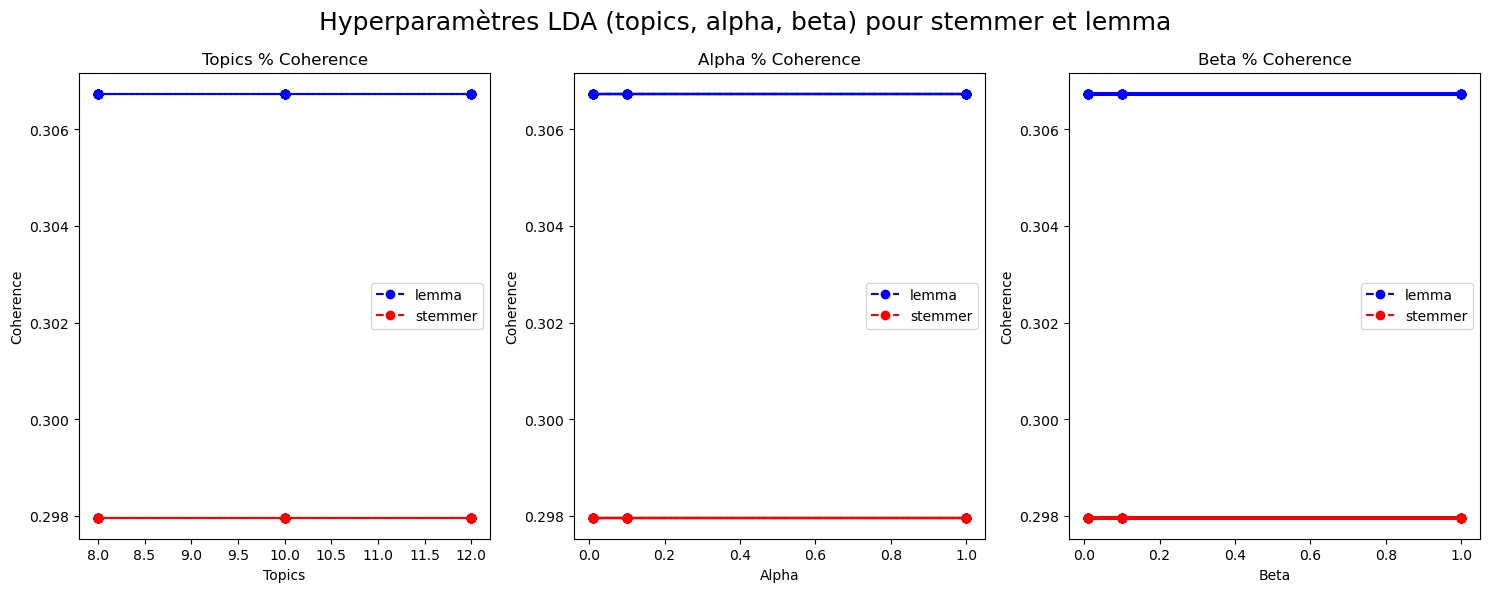

In [49]:
LDA_affichage_hyperparametres()

In [ ]:
#####################################################
# 4) Final Model                                    #
#####################################################

In [53]:
# Maj hyperparamètres : on prend la 1ère valeur de la plage car ils donnent tous le même résultat.
# Remarque : la cohérence est meilleure pour lemma que stemmer.
num_topics = 8    # Number of Topics
alpha      = 0.01 # Alpha parameter
beta       = 0.01 # Beta parameter

In [54]:
lda_model_lemma = gensim.models.LdaMulticore(corpus       = corpus_lemma,
                                             id2word      = id2word_lemma,
                                             num_topics   = num_topics, # hyperparamètre
                                             random_state = 100,
                                             chunksize    = 100,
                                             passes       = 10,
                                             alpha        = alpha,      # hyperparamètre
                                             eta          = beta)       # hyperparamètre

In [55]:
lda_model_stemmer = gensim.models.LdaMulticore(corpus       = corpus_stemmer,
                                               id2word      = id2word_stemmer,
                                               num_topics   = num_topics, # hyperparamètre
                                               random_state = 100,
                                               chunksize    = 100,
                                               passes       = 10,
                                               alpha        = alpha,      # hyperparamètre
                                               eta          = beta)       # hyperparamètre

In [66]:
#####################################################
# 5) Visualize Results                              #
#####################################################
def LDA_Visualize_Results(normalization_type_in, corpus_in, id2word_in, lda_model_in):

    # Visualize the topics
    pyLDAvis.enable_notebook()

    LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+ str(num_topics))

    # this is a bit time consuming - make the if statement True
    # if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = gensimvis.prepare(lda_model_in, corpus_in, id2word_in)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    
    if (normalization_type_in == 'lemma'):
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_lemma_'+ str(num_topics) +'.html')
    elif (normalization_type_in == 'stemmer'):
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_stemmer_'+ str(num_topics) +'.html')
    else:
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

    LDAvis_prepared

In [67]:
LDA_Visualize_Results(normalization_type_in = 'lemma', 
                      corpus_in             = corpus_lemma, 
                      id2word_in            = id2word_lemma, 
                      lda_model_in          = lda_model_lemma)

In [68]:
LDA_Visualize_Results(normalization_type_in = 'stemmer', 
                      corpus_in             = corpus_stemmer, 
                      id2word_in            = id2word_stemmer, 
                      lda_model_in          = lda_model_stemmer)

In [ ]:
# transformation manuelle du fichier html --> jpg

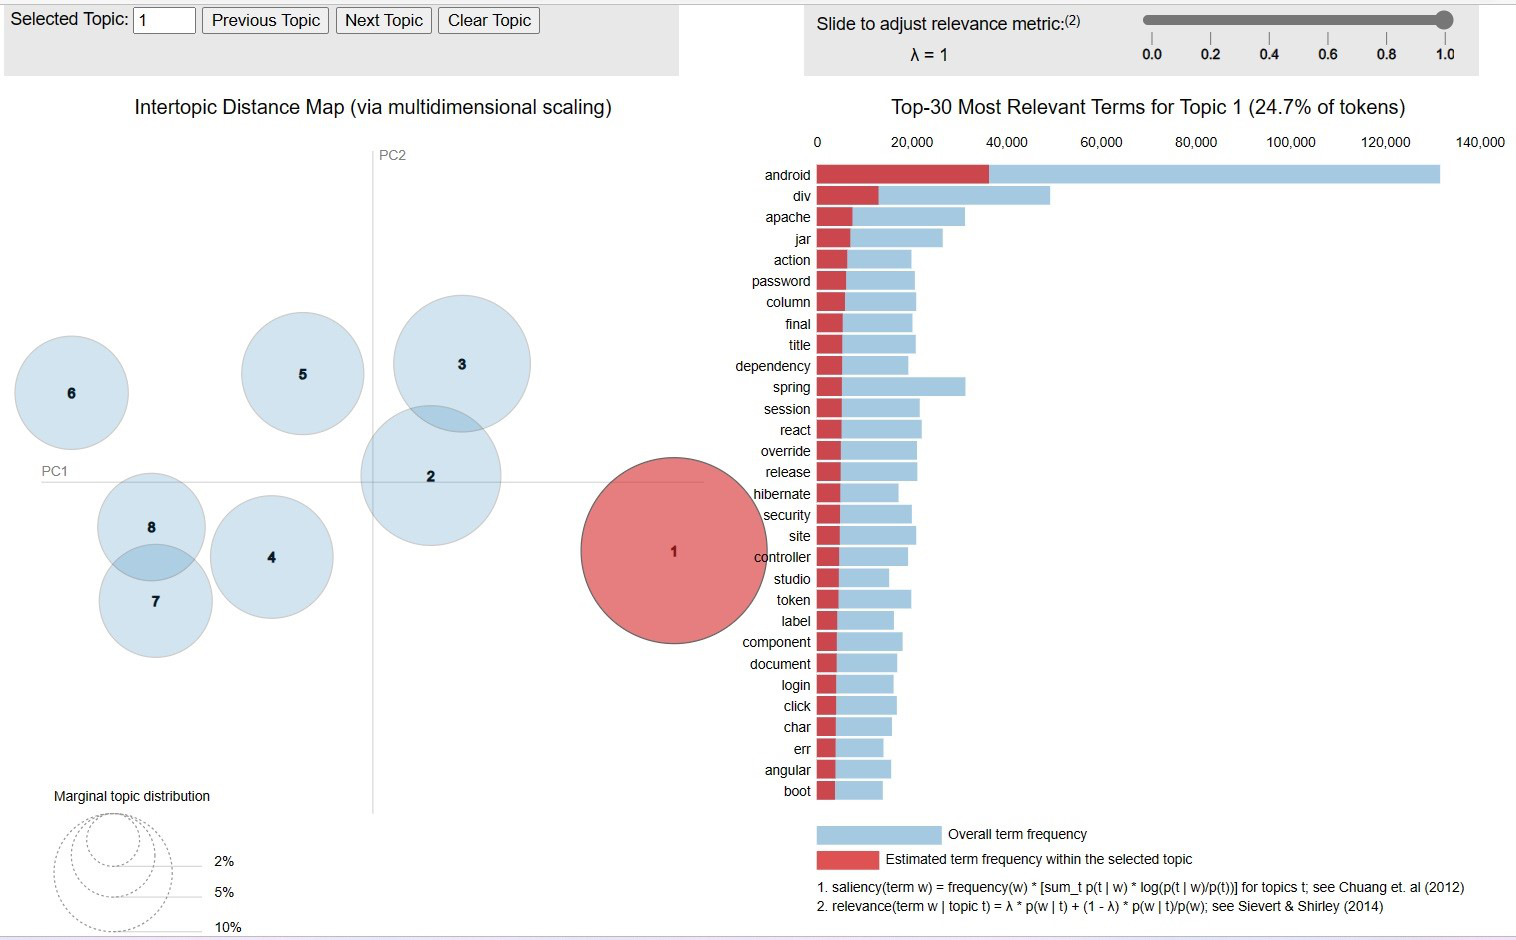

In [57]:
Image.open('./results/ldavis_tuned_lemma_8.jpg')

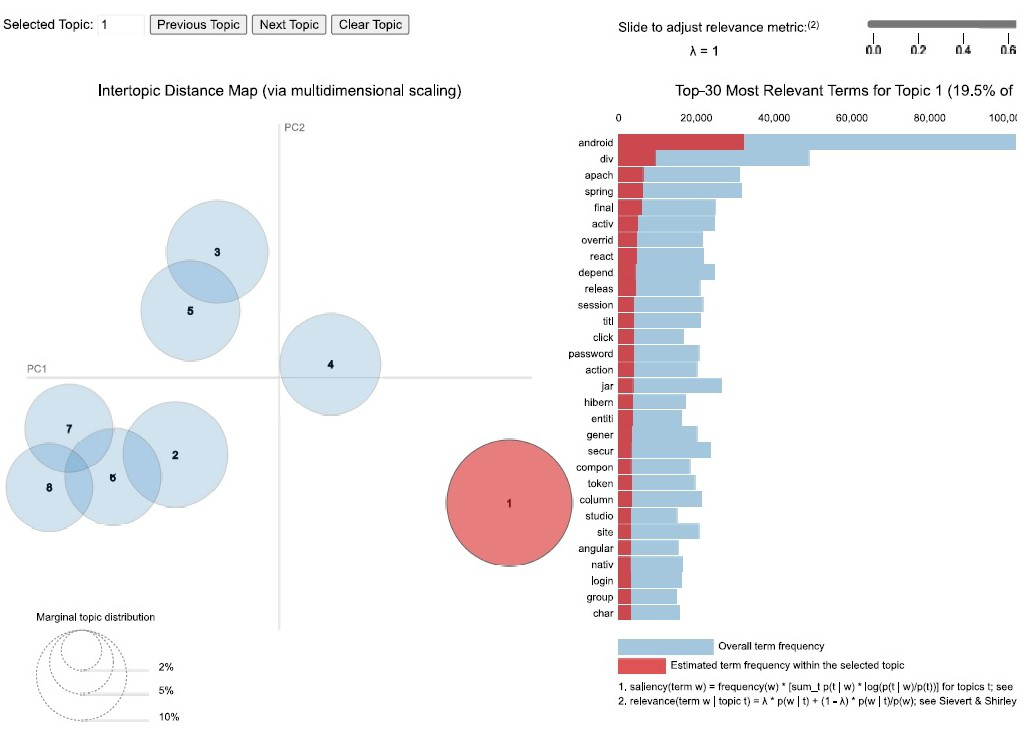

In [56]:
Image.open('./results/ldavis_tuned_stemmer_8.jpg')

# 3. MACHINE LEARNING SUPERVISE

# 3.1. EXTRACTION DES DONNEES

In [80]:
df.columns

Index(['Id', 'Score', 'AnswerCount', '_Tag_1', '_Tag_2', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_Tokens_text_clean',
       '_Tokens_stemmer_clean', '_Tokens_lemma_clean'],
      dtype='object')

In [81]:
df.head()

,Id,Score,AnswerCount,_Tag_1,_Tag_2,_Text_clean,_Stemmer_clean,_Lemma_clean,_Tokens_text_clean,_Tokens_stemmer_clean,_Tokens_lemma_clean
0,3881,570,26,java,exception,torn,torn,torn,['torn'],['torn'],['torn']
1,4306,62,11,c++,/,sparse enormous matrices summation copula rare...,spars enorm matric summat copula rare sea mult...,sparse enormous matrix summation copula rare s...,"['sparse', 'enormous', 'matrices', 'summation'...","['spars', 'enorm', 'matric', 'summat', 'copula...","['sparse', 'enormous', 'matrix', 'summation', ..."
2,6915,38,9,c++,multithreading,construction lazily beforehand construction in...,construct lazili beforehand construct integr g...,construction lazily beforehand construction in...,"['construction', 'lazily', 'beforehand', 'cons...","['construct', 'lazili', 'beforehand', 'constru...","['construction', 'lazily', 'beforehand', 'cons..."
3,4511,17,2,sql,sql-server,transact,transact,transact,['transact'],['transact'],['transact']
4,4157,27,8,c#,.net,radio regard needing,radio regard need,radio regard needing,"['radio', 'regard', 'needing']","['radio', 'regard', 'need']","['radio', 'regard', 'needing']"


# 3.1.1. EXTRACTION DONNEES X

In [ ]:
###############################################
# X : données d'entrée                        #
###############################################

In [ ]:
###############################################
# 1) COLONNES NUMERIQUES                      #
###############################################

In [82]:
# Colonnes :
# --> numériques (à garder)        : 'Id', 'Score', 'AnswerCount', 
# --> y                            : '_Tag_1', '_Tag_2', 
# --> liste de tokens              : '_Text_clean', '_Stemmer_clean', '_Lemma_clean', 
# --> tokens séparés par un espace : '_Tokens_text_clean', '_Tokens_stemmer_clean', '_Tokens_lemma_clean',

# On supprime les y (__Tag_1 et _Tag_2) et les colonnes texte (_xxx_clean) pour ne garder que les colonnes numériques.
df_num = df.drop(['_Tag_1', '_Tag_2',
                  '_Text_clean', '_Stemmer_clean', '_Lemma_clean', 
                  '_Tokens_text_clean', '_Tokens_stemmer_clean', '_Tokens_lemma_clean'], axis = 1)

# Affichage pour vérifier
print('@' * 30, 'df_num', '@' * 30)
print('>' * 7, 'SHAPE :', df_num.shape, '\n')
print('>' * 7, 'COLUMNS :', df_num.columns, '\n')
print('>' * 7, 'HEAD :\n', df_num.head(), '\n\n')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ df_num @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
>>>>>>> SHAPE : (187949, 3) 

>>>>>>> COLUMNS : Index(['Id', 'Score', 'AnswerCount'], dtype='object') 

>>>>>>> HEAD :
      Id  Score  AnswerCount
0  3881    570           26
1  4306     62           11
2  6915     38            9
3  4511     17            2
4  4157     27            8 




In [ ]:
###############################################
# 2) COLONNE TEXTE                            #
###############################################
# Travail à part dans les 2 colonnes texte (de manière isolée) :
#   ---> Colonne '_Stemmer_clean' --> corpus_liste_doc_stemmer
#   ---> Colonne '_Lemma_clean' ----> corpus_liste_doc_lemma
#
# corpus = ['This is the first document.',
#           'This document is the second document.',
#           'And this is the third one.',
#           'Is this the first document?']

# 3.1.1.1. APPROCHE BOW / COUNTVECTORIZER

In [ ]:
###########################################################################################################################
# EXTRACTION DE FEATURE A PARTIR DU TEXTE <=> nous créons une matrice de valeurs numériques pour représenter notre texte  #
# APPROCHE DE TYPE BAG-OF-WORDS (BOW) <=> 2 méthodes : CountVectorizer / TfidfVectorizer                                  #
###########################################################################################################################
# https://andhint.github.io/machine-learning/nlp/Feature-Extraction-From-Text/
# https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

In [83]:
###################################################
# Méthode CountVectorizer                         #
###################################################
# CountVectorizer :
#  --> convertit le texte en données numériques.
#  --> adopte une approche bag-of-words (sac de mots) : chaque message est séparé en jetons et le nombre de fois 
#      où chaque jeton apparaît dans un message est compté.

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vect_stemmer = CountVectorizer()
vect_lemma   = CountVectorizer()

In [ ]:
#------------------------------------------------------------------------------------------------#
# Méthode fit :                                                                                  #
#------------------------------------------------------------------------------------------------#
# CountVectorizer() va apprendre quels tokens sont utilisés dans notre corpus_liste_doc_xxx.     #
# corpus list : one string for one document :                                                    #
# corpus = ['This is the first document.',                                                       #
#           'This document is the second document.',                                             #
#           'And this is the third one.',                                                        #
#           'Is this the first document?']                                                       #
#------------------------------------------------------------------------------------------------#

In [84]:
vect_stemmer.fit(corpus_liste_doc_stemmer)

CountVectorizer()

In [85]:
vect_lemma.fit(corpus_liste_doc_lemma)

CountVectorizer()

In [ ]:
#------------------------------------------------------------------------------------------------#
# Vocabulaire :                                                                                  #
# liste de mots uniques, identifés par leur indice dans la matrice                               #
#------------------------------------------------------------------------------------------------#

In [86]:
print(len(vect_stemmer.vocabulary_), 'mots de vocabulaire pour stemmer\n')

# Affichage des 20 premiers mots
res = dict(list(vect_stemmer.vocabulary_.items())[0:20])    
print('20 premiers mots du dictionnaire :', str(res), '\n')

#print('Stemmer vocabulary :', vect_stemmer.vocabulary_)

# Vérification avec le corpus stemmer (corpus_stemmer --> token_stemmer --> count_stemmer)
print('corpus_stemmer =', len(count_stemmer.index.tolist()), 'mots uniques')

11219 mots de vocabulaire pour stemmer

20 premiers mots du dictionnaire : {'torn': 9962, 'spars': 8985, 'enorm': 3086, 'matric': 5725, 'summat': 9404, 'copula': 2080, 'rare': 7650, 'sea': 8429, 'multidimension': 6100, 'preset': 7299, 'physic': 6975, 'construct': 2011, 'lazili': 5258, 'beforehand': 855, 'integr': 4763, 'guard': 4085, 'excel': 3225, 'shame': 8564, 'broad': 1199, 'pod': 7118} 

corpus_stemmer = 11219 mots uniques


In [87]:
print(len(vect_lemma.vocabulary_), 'mots de vocabulaire pour lemma\n')

# Affichage des 20 premiers mots
res = dict(list(vect_lemma.vocabulary_.items())[0:20])    
print('20 premiers mots du dictionnaire :', str(res), '\n')

#print('Lemma vocabulary :', vect_lemma.vocabulary_)

# Vérification avec le corpus stemmer (corpus_lemma --> token_lemma --> count_lemma)
print('corpus_lemma =', len(count_lemma.index.tolist()), 'mots uniques')

14349 mots de vocabulaire pour lemma

20 premiers mots du dictionnaire : {'torn': 12803, 'sparse': 11605, 'enormous': 4091, 'matrix': 7486, 'summation': 12142, 'copula': 2712, 'rare': 9871, 'sea': 10920, 'multidimensional': 7932, 'preset': 9430, 'physically': 9010, 'construction': 2594, 'lazily': 6909, 'beforehand': 1130, 'integral': 6301, 'guard': 5393, 'excellent': 4284, 'shame': 11101, 'broad': 1536, 'pod': 9175} 

corpus_lemma = 14349 mots uniques


In [ ]:
#------------------------------------------------------------------------------------------------#
# Méthode get_feature_names :                                                                    #
# liste des features créées pour nos messages (ou qui ont été apprises par CountVectorizer)      #
#------------------------------------------------------------------------------------------------#

In [88]:
print(len(vect_stemmer.get_feature_names()), 'stemmer feature_names\n')
print(vect_stemmer.get_feature_names()[0:30])

11219 stemmer feature_names

['aa', 'aal', 'aardvark', 'aaron', 'ab', 'aba', 'abac', 'abandon', 'abas', 'abb', 'abba', 'abbrevi', 'abe', 'abel', 'aberr', 'abi', 'abid', 'abigail', 'abil', 'abnorm', 'abo', 'aboard', 'abomin', 'abort', 'about', 'abraham', 'abridg', 'abrupt', 'abruptli', 'absenc']


C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [89]:
print(len(vect_lemma.get_feature_names()), 'lemma feature_names\n')
print(vect_lemma.get_feature_names()[0:30])

14349 lemma feature_names

['aa', 'aal', 'aardvark', 'aaron', 'ab', 'aba', 'abac', 'abandon', 'abandoned', 'abase', 'abb', 'abba', 'abbreviate', 'abbreviation', 'abe', 'abel', 'aberrant', 'abide', 'abiding', 'abigail', 'ability', 'abnormal', 'abnormally', 'abo', 'aboard', 'abomination', 'abort', 'aborted', 'abouts', 'abraham']


In [ ]:
#------------------------------------------------------------------------------------------------------#
# DTM (Document Term Matrix) :                                                                         #
# Sparse matrix <=> compressed sparse row format : le corpus se répartit sur 19281 features différents #
# <=> les lignes seront remplies avec une majorité de zéros.                                           #
#------------------------------------------------------------------------------------------------------#

In [90]:
dtm_lemma = vect_lemma.transform(corpus_liste_doc_lemma)
repr(dtm_lemma)

"<187949x14349 sparse matrix of type '<class 'numpy.int64'>'\n\twith 1141281 stored elements in Compressed Sparse Row format>"

In [91]:
dtm_stemmer = vect_lemma.transform(corpus_liste_doc_stemmer)
repr(dtm_stemmer)

"<187949x14349 sparse matrix of type '<class 'numpy.int64'>'\n\twith 677447 stored elements in Compressed Sparse Row format>"

In [92]:
print(dtm_lemma)

  (0, 12803)	1
  (1, 2712)	1
  (1, 4091)	1
  (1, 7486)	1
  (1, 7932)	1
  (1, 9010)	1
  (1, 9430)	1
  (1, 9871)	1
  (1, 10920)	1
  (1, 11605)	2
  (1, 12142)	1
  (2, 829)	1
  (2, 1130)	1
  (2, 1404)	1
  (2, 1536)	1
  (2, 1910)	1
  (2, 2594)	2
  (2, 4284)	1
  (2, 5393)	1
  (2, 6301)	1
  (2, 6779)	1
  (2, 6909)	1
  (2, 9175)	1
  (2, 11101)	1
  (3, 12882)	1
  :	:
  (187946, 1446)	1
  (187946, 3326)	2
  (187946, 5951)	1
  (187946, 7028)	2
  (187946, 12499)	1
  (187947, 769)	1
  (187947, 1446)	1
  (187947, 1759)	2
  (187947, 1826)	1
  (187947, 4884)	6
  (187947, 4886)	1
  (187947, 6844)	1
  (187947, 7972)	1
  (187947, 8893)	1
  (187947, 11550)	1
  (187947, 12333)	1
  (187947, 13381)	1
  (187947, 13560)	1
  (187947, 14066)	1
  (187948, 1026)	2
  (187948, 1193)	1
  (187948, 4366)	1
  (187948, 6359)	1
  (187948, 8560)	1
  (187948, 10822)	9


In [93]:
print(dtm_stemmer)

  (0, 12803)	1
  (1, 2712)	1
  (1, 9008)	1
  (1, 9430)	1
  (1, 9871)	1
  (1, 10920)	1
  (2, 828)	1
  (2, 1130)	1
  (2, 1404)	1
  (2, 1536)	1
  (2, 2592)	2
  (2, 4283)	1
  (2, 5393)	1
  (2, 6779)	1
  (2, 9175)	1
  (2, 11101)	1
  (3, 12882)	1
  (4, 9810)	1
  (4, 10129)	1
  (5, 10275)	1
  (5, 14172)	1
  (6, 2141)	1
  (6, 5539)	2
  (7, 247)	1
  (7, 751)	1
  :	:
  (187941, 12383)	1
  (187942, 6844)	4
  (187942, 12303)	1
  (187943, 3198)	2
  (187943, 7667)	1
  (187943, 9246)	3
  (187943, 9852)	1
  (187945, 2054)	4
  (187945, 3774)	3
  (187945, 5558)	8
  (187945, 9778)	1
  (187945, 10983)	6
  (187946, 1446)	1
  (187946, 3326)	2
  (187947, 767)	1
  (187947, 1446)	1
  (187947, 1826)	1
  (187947, 4884)	7
  (187947, 6844)	1
  (187947, 8893)	1
  (187947, 12333)	1
  (187948, 1026)	2
  (187948, 4195)	2
  (187948, 6357)	1
  (187948, 10822)	9


In [ ]:
#------------------------------------------------------------------------------------------------------#
# Conversion spare matrix --> dense matrix (pour gagner de la place)                                   #
#------------------------------------------------------------------------------------------------------#

In [94]:
df_lemma = pd.DataFrame(dtm_lemma.toarray(), columns = vect_lemma.get_feature_names())
print(df_lemma)

MemoryError: Unable to allocate 20.1 GiB for an array with shape (187949, 14349) and data type int64

In [402]:
df_stemmer = pd.DataFrame(dtm_stemmer.toarray(), columns = vect_stemmer.get_feature_names())
print(df_stemmer)

In [43]:
df_lemma.columns

NameError: name 'df_lemma' is not defined

In [ ]:
###############################################
# 3) MERGE DES 2 DATAFRAMES                   #
###############################################

In [1]:
print('df_num shape\t=', df_num.shape)
print('df_lemma shape\t=', df_lemma.shape)

NameError: name 'df_num' is not defined

In [ ]:
#############################################
#        X_lemma = df_num + df_lemma        #
#############################################
# how = inner (valeur par défaut) <=> clés présentes dans les 2 dataframes(cela évite les cellules NaN).

X_lemma = pd.merge(df_num, df_lemma, on = index)

In [ ]:
#############################################
#     X_stemmer = df_num + df_stemmer       #
#############################################
X_stemmer = pd.merge(df_num, df_stemmer, on = index)

In [ ]:
print('X_lemma shape\t=', X_lemma.shape)
print('X_stemmer shape\t=', X_stemmer.shape)

# 3.1.2. EXTRACTION DONNEES Y

In [ ]:
###############################################
# y : données de sortie (résultat)            #
###############################################

In [95]:
# Copie des 2 sorties y (_Tag_1 et _Tag_2) dans un dataframe.
df_y = df[['_Tag_1', '_Tag_2']].copy()
df_y.shape

(187949, 2)

In [96]:
# Vérification n°1
for index, row in df.iterrows():
    if (row['_Tag_1'] != df_y.loc[index, '_Tag_1']):
        print('index =', index, ': _Tag_1 différent : df =', row['_Tag_1'], ', df_y =', df_y.loc[index, '_Tag_1'])
    if (row['_Tag_2'] != df_y.loc[index, '_Tag_2']):
        print('index =', index, ': _Tag_2 différent : df =', row['_Tag_2'], ', df_y =', df_y.loc[index, '_Tag_2'])

In [97]:
# Vérification n°2
print('@' * 16, 'df - head :', '@' * 16, '\n', df[['_Tag_1', '_Tag_2']].head(), '\n\n')
print('@' * 15, 'df_y - head :', '@' * 15, '\n', df_y.head(), '\n\n')

print('@' * 16, 'df - tail :', '@' * 16, '\n', df[['_Tag_1', '_Tag_2']].tail(), '\n\n')
print('@' * 15, 'df_y - tail :', '@' * 15, '\n', df_y.tail())

@@@@@@@@@@@@@@@@ df - head : @@@@@@@@@@@@@@@@ 
   _Tag_1          _Tag_2
0   java       exception
1    c++               /
2    c++  multithreading
3    sql      sql-server
4     c#            .net 


@@@@@@@@@@@@@@@ df_y - head : @@@@@@@@@@@@@@@ 
   _Tag_1          _Tag_2
0   java       exception
1    c++               /
2    c++  multithreading
3    sql      sql-server
4     c#            .net 


@@@@@@@@@@@@@@@@ df - tail : @@@@@@@@@@@@@@@@ 
             _Tag_1    _Tag_2
187954  javascript         /
187955      python  selenium
187956         c++         /
187957         c++         /
187958  javascript   reactjs 


@@@@@@@@@@@@@@@ df_y - tail : @@@@@@@@@@@@@@@ 
             _Tag_1    _Tag_2
187954  javascript         /
187955      python  selenium
187956         c++         /
187957         c++         /
187958  javascript   reactjs


In [98]:
# Conversion dataframe --> liste
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ Y : df_y --> list_y                                    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# https://stacklima.com/comment-convertir-pandas-dataframe-en-une-liste/
list_y = df_y.values.tolist()

# Vérification
print('list_y :')
print('\t- nb éléments\t\t=', len(list_y))
print('\t- 5 premiers éléments\t=', list_y[0:5])

list_y :
	- nb éléments		= 187949
	- 5 premiers éléments	= [['java', 'exception'], ['c++', '/'], ['c++', 'multithreading'], ['sql', 'sql-server'], ['c#', '.net']]


In [99]:
########################################################################################################
# Nous sommes dans un cas de Multi-label text classification, car la sortie est sur _Tag_1 et _Tag_2.  #
# => Transform between iterable of iterables and a multilabel format.                                  #
########################################################################################################


# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
# https://scikit-learn.org/stable/modules/preprocessing_targets.html
# https://medium.com/analytics-vidhya/multi-label-text-classification-for-beginners-in-less-than-five-5-minutes-19502a96cf39

mlb = MultiLabelBinarizer()

#----------------------------------------------------------------------------------------------
# fit_transform(y) : Fit the label sets binarizer and transform the given label sets.
# Parameters:
#   - y : iterable of iterables.
#     A set of labels (any orderable and hashable object) for each sample. If the classes parameter is set, 
#     y will not be iterated.

# Returns:
#    - y_indicator{ndarray, sparse matrix} of shape (n_samples, n_classes).
#      A matrix such that y_indicator[i, j] = 1 iff classes_[j] is in y[i], and 0 otherwise. 
#      Sparse matrix will be of CSR format.
#----------------------------------------------------------------------------------------------
mlb_indicator = mlb.fit_transform(list_y)

print(type(mlb_indicator))
mlb_indicator

<class 'numpy.ndarray'>


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [100]:
print('classes_ :')
print('\t- nb éléments\t=', len(mlb.classes_))
print('\t- liste\t\t=\n', mlb.classes_)

classes_ :
	- nb éléments	= 100
	- liste		=
 ['.net' '/' 'ajax' 'algorithm' 'amazon-web-services' 'android'
 'android-studio' 'angular' 'angularjs' 'api' 'arrays' 'asp.net'
 'asp.net-core' 'asp.net-mvc' 'assembly' 'asynchronous' 'authentication'
 'bash' 'c' 'c#' 'c++' 'c++11' 'cocoa' 'cocoa-touch' 'css' 'database'
 'dataframe' 'debugging' 'django' 'docker' 'eclipse' 'entity-framework'
 'exception' 'firebase' 'gcc' 'git' 'google-chrome' 'gradle' 'hibernate'
 'html' 'http' 'image' 'ios' 'iphone' 'java' 'javascript' 'jpa' 'jquery'
 'json' 'laravel' 'linux' 'list' 'machine-learning' 'macos' 'maven'
 'mongodb' 'multithreading' 'mysql' 'node.js' 'numpy' 'objective-c'
 'optimization' 'pandas' 'performance' 'php' 'postgresql' 'python'
 'python-2.7' 'python-3.x' 'qt' 'r' 'reactjs' 'regex' 'rest' 'ruby'
 'ruby-on-rails' 'scala' 'security' 'selenium' 'shell' 'spring'
 'spring-boot' 'spring-mvc' 'sql' 'sql-server' 'ssl' 'string' 'swift'
 'templates' 'testing' 'twitter-bootstrap' 'typescript' 'ubun

In [101]:
#y = np.array(mlb)
y = mlb_indicator

In [102]:
y.shape

(187949, 100)

In [103]:
print(y)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# 3.2. REDUCTION DE DIMENSION (ACP)

In [ ]:
# https://ichi.pro/fr/analyse-en-composantes-principales-acp-avec-scikit-learn-33554981925296
# https://stacklima.com/analyse-des-composants-principaux-avec-python/

In [107]:
###########################################################################################
# ACP sur notre ensemble de données pour voir comment il capture la variance des données. #
###########################################################################################
def PCA_all(data_in):
    
    # Nombre de colonnes
    nb_colonnes = len(data_in.columns)
    print('nb_colonnes = ', nb_colonnes)
    
    
    # PCA sur l'ensemble des données
    pca_all = PCA(n_components = nb_colonnes)
    pca_all.fit(data_in)
    
    
    # Explained variance
    pca_all.explained_variance_ratio_  

    # Variance captée pour chaque composante
    scree = (pca_all.explained_variance_ratio_ * 100).round(2)
    print('scree =', scree)

    # Somme cumulée
    scree_cum = scree.cumsum().round()
    print('scree_cum =', scree_cum)

    # Variable avec la liste de nos composantes :
    x_list = range(1, n_components + 1)
    list(x_list)

    # Graphique éboulis des valeurs graphiques (scree plot)
    # Remarque : on a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum, c = 'red', marker = 'o')
    plt.xlabel('Rang de l\'axe d\'inertie')
    plt.ylabel('Pourcentage d\'inertie')
    plt.title('Eboulis des valeurs propres')
    plt.show(block = False)

In [ ]:
def PCA_reduit(data_in, n_components_in):
    
    # Appliquons PCA sur un nombre réduit de composants
    pca_reduit = PCA(n_components = n_components_in)
    pca_reduit.fit(data_in)
    data_pca_reduit = pca_reduit.transform(data_in)
    
    return data_pca_reduit

In [ ]:
#############################################
# PCA pour X_lemma                          #
#############################################

In [ ]:
# PCA sur toutes les données
PCA_all(data_in = X_lemma)

Commentaire...
On voit ici que près de 80% de la variance est comprise dans les 3 premières composantes, 
et près de 90% dans les 4 premières.

In [ ]:
X_lemma_pca_2 = PCA_reduit(data_in         = X_lemma,
                           n_components_in = 2)

In [ ]:
#############################################
# PCA pour X_stemmer                        #
#############################################

In [ ]:
# PCA sur toutes les données
PCA_all(data_in = X_stemmer)

Commentaire...

In [ ]:
X_stemmer_pca_2 = PCA_reduit(data_in         = X_stemmer,
                             n_components_in = 2)

In [ ]:
#############################################
# PCA pour y                                #
#############################################

In [ ]:
# PCA sur toutes les données
PCA_all(data_in = y)

Commentaire...

In [ ]:
y_pca_10 = PCA_reduit(data_in         = y,
                     n_components_in = 10)

# 3.3. DECOUPAGE DONNEES TRAIN / TEST

In [ ]:
# Découpage des données X, y en données d'entrainement et de test
def decoupage_train_test(X_in, y_in):
    
    X_train, X_test, y_train, y_test = train_test_split(X_in, y_in, random_state = 42) # test_size = 0.25, train_size = 0.75

    # Vérification
    print('X_train\t=', X_train.shape)
    print('X_test\t=',  X_test.shape)
    print('y_train\t=', y_train.shape)
    print('y_test\t=',  y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [ ]:
##################################################
#                Données stemmer                 #
##################################################
X_train_stemmer, X_test_stemmer, y_train_stemmer, y_test_stemmer = decoupage_train_test(X_in = X_stemmer_pca_2,
                                                                                        y_in = y_pca_2)

In [ ]:
##################################################
#                 Données lemma                  #
##################################################
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = decoupage_train_test(X_in = X_lemma_pca_2,
                                                                                y_in = y_pca_2)

# 3.4. ALGORITHMES

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

In [ ]:
def algorithme_ovr(model_in, X_train_in, y_train_in, X_test_in):
    
    # Define model
    model = model_in

    # Define the ovr (one-vs-rest) strategy
    ovr = OneVsRestClassifier(model)

    # Fitting the model with training data
    ovr.fit(X_train_in, y_train_in)
    
    # Making a prediction on the test set
    y_pred = ovr.predict(X_test_in)
    
    return y_pred    

In [ ]:
###################################################
# Métriques pour évaluer le modèle                #
###################################################
def metriques_algo(y_test_in, y_pred_in):

    # Accuracy
    print(f"Test Set Accuracy = {accuracy_score(y_test_in, y_pred_in) * 100} %\n\n")

    # Classification report
    print(f"Classification Report = \n\n{classification_report(y_test_in, y_pred_in)}")

    # F1 score
    print('F1 score =', f1_score(y_test_in, y_pred_in))

    # Matrice de confusion
    sns.heatmap(confusion_matrix(y_test_in, y_pred_in), annot = True)
    plt.ylabel('Classes réelles')
    plt.xlable('Classes prédites')
    plt.title('Matrice de confusion')
    plt.show()

# 3.4.1. ALGORITHME SVM (SUPPORT VECTOR MACHINE)

In [ ]:
# https://www.actuia.com/contribution/victorbigand/tutoriel-tal-pour-les-debutants-classification-de-texte/
# https://www.geeksforgeeks.org/one-vs-rest-strategy-for-multi-class-classification/

# l'algorithme SVM (Support Vector Machine) :
# ---> Permet de réaliser des tâches de classification ou de régression.
# ---> Fonctionne bien sur des données textuelles, même si il est aujourd'hui largement surpassé par les réseaux 
#     de neurones profonds.
# ---> Sépare au maximum les exemples tirés des différentes classes.
# ---> Est un algorithme de classification binaire que nous utilisons avec l'heuristique One-vs-Rest pour effectuer
#      une classification multiclasse.

In [ ]:
##################################################
#                Données stemmer                 #
##################################################

In [ ]:
# Modèle SVC
y_pred_stemmer_svc = algorithme_ovr(model_in   = SVC(), 
                                    X_train_in = X_train_stemmer, 
                                    y_train_in = y_train_stemmer, 
                                    X_test_in  = X_test_stemmer)

In [ ]:
algo_metriques(y_test_in = y_test_stemmer,
               y_pred_in = y_pred_stemmer_svc)

In [ ]:
# Modèle LinearSVC
y_pred_stemmer_LinearSVC = algorithme_ovr(model_in   = LinearSVC(), 
                                          X_train_in = X_train_stemmer, 
                                          y_train_in = y_train_stemmer, 
                                          X_test_in  = X_test_stemmer)

In [ ]:
algo_metriques(y_test_in = y_test_stemmer,
               y_pred_in = y_pred_stemmer_LinearSVC)

In [ ]:
##################################################
#                 Données lemma                  #
##################################################
# Modèle SVC
y_pred_lemma_svc = algorithme_ovr(model_in   = SVC(), 
                                  X_train_in = X_train_lemma, 
                                  y_train_in = y_train_lemma, 
                                  X_test_in  = X_test_lemma)

In [ ]:
algo_metriques(y_test_in = y_test_lemma,
               y_pred_in = y_pred_lemma_svc)

In [ ]:
# Modèle LinearSVC
y_pred_lemma_LinearSVC = algorithme_ovr(model_in   = LinearSVC(), 
                                        X_train_in = X_train_lemma, 
                                        y_train_in = y_train_lemma, 
                                        X_test_in  = X_test_lemma)

In [ ]:
algo_metriques(y_test_in = y_test_lemma,
               y_pred_in = y_pred_lemma_LinearSVC)

# 3.4.2. ALGORITHME LOGISTIC REGRESSION

In [ ]:
# https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

In [ ]:
##################################################
#                Données stemmer                 #
##################################################

In [ ]:
y_pred_stemmer_logreg = algorithme_ovr(model_in   = LogisticRegression(),
                                       X_train_in = X_train_stemmer, 
                                       y_train_in = y_train_stemmer, 
                                       X_test_in  = X_test_stemmer)

In [ ]:
algo_metriques(y_test_in = y_test_stemmer,
               y_pred_in = y_pred_stemmer_logreg)    

In [ ]:
##################################################
#                 Données lemma                  #
##################################################
y_pred_lemma_logreg = algorithme_ovr(model_in   = LogisticRegression(),
                                     X_train_in = X_train_lemma, 
                                     y_train_in = y_train_lemma, 
                                     X_test_in  = X_test_lemma)

In [ ]:
algo_metriques(y_test_in = y_test_lemma,
               y_pred_in = y_pred_lemma_logreg)